In [1]:
import sys ; sys.path.insert(0, '../')
from notebook_tools import *
import matplotlib.mlab as mlab
%matplotlib inline

Welcome to ROOTaaS 6.06/02

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!
Error in <TProtoClass::FindDataMember>: data member with index 0 is not found in class locale
Error in <CreateRealData>: Cannot find data member # 0 of class locale for parent GenerateEvents!


In [2]:
from scipy.interpolate import interp1d, Akima1DInterpolator,BarycentricInterpolator,splprep

ColleCalc = pd.DataFrame({'A':[4,12 , 27 , 56 , 208],
                        'allpairs':[110,141,146,147.5,145.5],# average of HO and WS
                        'nl00':[110,157,166,173.,177.5]},# average of HO and WS
                         index = ['$^{4}$He','$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb'])
CiofiCalc = pd.DataFrame({'A':[4 , 12 , 40 , 56 , 208], # 3 , 
                        's_t':[90 , 138.6174 , 142.6555 , 132.5117 , 151.3311]}, # 0.0724
                         index = ['$^{4}$He','$^{12}$C','$^{40}$Ca','$^{56}$Fe','$^{208}$Pb']) # '$^{3}$He',
MonizCalc = pd.DataFrame({'A':[12 , 40 , 208],
                        '3kF/4':[165.8 , 188.3 , 198.8]},
                         index = ['$^{12}$C','$^{40}$Ca','$^{208}$Pb'])
BNL_Data = pd.DataFrame({'A':[12],'sigma_t_final':[0.143],'sigma_t_final_Err':[0.017]},index = ['$^{12}$C'])
HallA_Data = pd.DataFrame({'A':[12],'sigma_t_final':[0.136],'sigma_t_final_Err':[0.020]},index = ['$^{12}$C'])
Korover_Data = pd.DataFrame({'A':[4],'sigma_t_final':[0.100],'sigma_t_final_Err':[0.020]},index = ['$^{4}$He'])
WI_Data = pd.DataFrame({'A':[ 12 , 27 , 56 , 208], 
                        'sigma_t_final':[0.158 , 0.156 , 0.181 , 0.174], 
                        'sigma_t_final_Err':[0.012 , 0.019 , 0.011 , 0.016]}, 
                         index = ['$^{12}$C','$^{27}$Al','$^{56}$Fe','$^{208}$Pb']) 

def plot_data(data , ax=None, direction='t', Ashift=0, fmt='o', marker='^',color='red',
                       markersize=15, linewidth=4, 
                       vary=None , varyerr=None , label=None , facecolors=None ):
    ax.errorbar((data['A']+Ashift), 
                y=1000*data['sigma_'+direction+'_final'],
                yerr=1000*data['sigma_'+direction+'_final_Err'],                
                color=color, marker=marker,markersize=markersize,linewidth=linewidth
                , fmt=fmt,label=label)
def plot_data_assymetric(data , ax=None, direction='t', Ashift=0, fmt='o', marker='^',color='red',
                       markersize=15, linewidth=4, 
                       vary=None , varyerr=None , label=None , facecolors=None ):
    ax.errorbar((data['A']+Ashift), 
                y=1000*data['sigma_'+direction+'_final'],
                yerr=[1000*data['sigma_'+direction+'_final_dw_err'],1000*data['sigma_'+direction+'_final_up_err']],
                color=color, marker=marker,markersize=markersize,linewidth=linewidth
                , fmt=fmt,label=label)        
def plot_calculation_line( data , varx='A',kind='nearest' , vary=None , color='blue' ,linestyle='--', label=None, linewidth=4):
    x = data[varx]
    y = data[vary]
    itp = interp1d(x,y, kind='linear')
    if kind is None:
        f = interp1d( x , y )
    else:
        f = interp1d( x , y ,kind=kind)
    window_size, poly_order = 101, 4
    xnew = np.linspace(x.min(),x.max(), num=500, endpoint=True)
    yy_sg = savgol_filter(itp(xnew), window_size, poly_order)
    plt.plot( xnew, yy_sg, linestyle, color=color , label=label, linewidth=linewidth )

In [3]:
def plot_needed_for_A_depdendence_sigma_t(ax=None,figsize=(16,15),s=30,
                                          xlim=(2.5,250), ylim=(0,200), #79
                                          labels=dict({'$^4$He':(3.5,122),
                                                '$^{12}$C':(9,165),
                                                '$^{27}$Al':(21,182),
                                                '$^{56}$Fe':(45,185),
                                                '$^{208}$Pb':(140,184),                                               
                                                      }),
                                          fontsize=55,
                                          do_Ciofi=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    # for all plots
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' , vary='allpairs',color='black' ,label='Colle et al., All pairs')
    plot_calculation_line( kind='slinear',data=ColleCalc, varx='A' ,linestyle='-',color='black', vary='nl00',label='Colle et al., $^1S_0$ pairs')
    if do_Ciofi: ax.errorbar(CiofiCalc.A, CiofiCalc.s_t,markeredgecolor='black',marker='*',ms=30,mfc='none',linewidth=0, markeredgewidth=2,label='Ciofi and Simula')
    plot_data( data=BNL_Data, ax=ax, Ashift=1 , color='blue', marker='s', label=None )
    plot_data( data=HallA_Data, ax=ax, Ashift=-1 , color='blue' , marker='s' , label='Hall-A/BNL' )
    plot_data( data=Korover_Data , ax=ax, marker='s' , color='blue', label=None )
    
    ax.set_xscale('log')
    set_axes(ax , 'A' , '$\sigma_{c.m.}$ [GeV/c]' , fontsize=fontsize 
             ,xticks=[4,12,27,56,208]
             ,yticks=[100,125,150,175,200])
    ax.grid(b=True, which='major', color='b', linestyle='--',alpha=0.25)    
    if xlim is not None:    ax.set_xlim(xlim);
    if ylim is not None:    ax.set_ylim(ylim);
    # target name labels
    for label in list(labels.keys()):
        ax.text(labels[label][0],labels[label][1],label,fontsize=35)
    return ax

def plot_A_depdendence_sigma_t(data=None,
                               figsize=(16,15),s=30,fontsize=55,
                               xlim=(2.5,250), ylim=(79,200),  #79
                               do_save_fig=True, filename='corrected_sigma_t_with_calculations',
                               labels=dict({'$^4$He':(3.5,122), '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,185), '$^{208}$Pb':(140,184), }),
                               do_Ciofi=True,do_measured=True,
                               do_stat_uncertainties=False,do_sys_uncertainties=False,do_tot_uncertainties=True):
    
    fig,ax = plt.subplots(figsize=figsize)
    ax=plot_needed_for_A_depdendence_sigma_t(ax=ax,figsize=figsize,fontsize=fontsize,s=s,xlim=xlim, ylim=ylim,labels=labels,do_Ciofi=do_Ciofi)
    # measured
    if do_measured: ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
    # corrected
    if do_tot_uncertainties:
        plot_data_assymetric( data=data, ax=ax, label='This work', markersize=20 ,color='red' , marker='o')
        
    # seperated statistical uncertainty
    if do_stat_uncertainties: 
        A,st,sterr = cm_pars['A'], 1000*data['sigma_t_final'], 1000*data['sigma_t_final_Err_stat']
        if do_tot_uncertainties:
            ax.errorbar(A,st,sterr ,ecolor='purple',elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')
        else: 
            ax.errorbar(A,st,sterr ,ecolor='red',color='red', marker='o', markersize=20 ,elinewidth=2 , capsize=15, capthick=3 , linestyle='none'
                        ,linewidth=3, label='stat. uncertainties')

#     ax.legend(fontsize=25,loc='lower right')
    # add a band of systematical uncertaintes
    if do_sys_uncertainties:
        ax.fill_between(cm_pars['A']
                        , np.min(ax.get_ylim())
                        , np.min(ax.get_ylim()) + 1000*data['sigma_t_final_up_err_sys'] 
                        , color='purple' , alpha=0.5 ,  label='sys. uncertainties')
    ax.legend(fontsize=25,loc='upper left')

# internal note v 3.3 Aug-20, 2017

# pp-SRC c.m. analysis

In [4]:
columns = ['Pmiss3Mag','pcmX','pcmY','pcmZ','rooWeight'] # ,'Mott','DipoleFF2'
data_allPmiss_PrecFid , data300Pmiss600_PrecFid = dict() , dict()
for target in ['C12','Al27','Fe56','Pb208']:
    data_allPmiss_PrecFid[target] = read_root( path+"/OrAnalysisTrees/AdjustedTrees/SRC_e2p_adjusted_300Pmiss600_%s_PrecFiducials.root"%target, columns=columns )
    data300Pmiss600_PrecFid[target] = data_allPmiss_PrecFid[target][data_allPmiss_PrecFid[target]['Pmiss3Mag']<0.6]

In [5]:
cm_parameters = dict()
cm_parameters_with_correction = dict()
for Fiducials in ["PrecFiducials"]:
    cm_pars = pd.read_csv('/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/300Pmiss600/alltargets_'+Fiducials+'_dataCMparameters.csv')
    cm_pars['sigma_x_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_x_unweighted']) - np.square(0.02))
    cm_pars['sigma_x_before_acc_corr_err'] = cm_pars['sigma_xErr_unweighted']
    cm_pars['sigma_y_before_acc_corr'] = np.sqrt(np.square(cm_pars['sigma_y_unweighted']) - np.square(0.02))
    cm_pars['sigma_y_before_acc_corr_err'] = cm_pars['sigma_yErr_unweighted']
    cm_pars['sigma_t_before_acc_corr'] = 0.5*(cm_pars['sigma_x_unweighted']+cm_pars['sigma_y_unweighted'])
    cm_pars['sigma_t_before_acc_corr_err'] = 0.5*np.sqrt(np.square(cm_pars['sigma_x_before_acc_corr_err'])+np.square(cm_pars['sigma_y_before_acc_corr_err']))
    cm_pars['Pval_x'] = 1 - stats.chi2.cdf(cm_pars['chi2red_x_unweighted'], 1)
    cm_pars['Pval_y'] = 1 - stats.chi2.cdf(cm_pars['chi2red_y_unweighted'], 1)
    cm_parameters[Fiducials] = cm_pars
    cm_parameters_with_correction[Fiducials] = cm_pars
cm_parameters[Fiducials]

,Nevts,chi2red_x_unweighted,chi2red_y_unweighted,chi2red_z_unweighted,mean_xErr_unweighted,mean_xErr_weighted,mean_x_unweighted,mean_x_weighted,mean_yErr_unweighted,mean_yErr_weighted,...,target,A,sigma_x_before_acc_corr,sigma_x_before_acc_corr_err,sigma_y_before_acc_corr,sigma_y_before_acc_corr_err,sigma_t_before_acc_corr,sigma_t_before_acc_corr_err,Pval_x,Pval_y
0,266,0.602767,0.407306,2.139232,0.009711,0.024008,-0.026697,0.004220,0.009910,0.019150,...,$^{12}$C,12,0.157110,0.006865,0.160396,0.007007,0.160008,0.004905,0.437524,0.523340
1,88,1.058674,0.542381,0.460758,0.019329,0.020803,-0.035170,-0.006808,0.017791,0.024075,...,$^{27}$Al,27,0.180235,0.013666,0.165708,0.012570,0.174126,0.009284,0.303518,0.461448
2,227,0.471936,0.458693,1.598486,0.011862,0.033590,-0.027254,-0.008921,0.012322,0.030910,...,$^{56}$Fe,56,0.177601,0.008388,0.184577,0.008706,0.182190,0.006045,0.492098,0.498236
3,45,0.847317,0.596230,0.395723,0.029217,0.050136,-0.024147,-0.032452,0.024489,0.040063,...,$^{208}$Pb,208,0.195017,0.020634,0.163082,0.017300,0.180172,0.013463,0.357312,0.440020


## cm_parameters['PrecFiducials']

In [6]:
targets = ['C','Al','Fe','Pb']
target_names = [r'$^{12}$C',r'$^{27}$Al',r'$^{56}$Fe',r'$^{208}$Pb']
As = [12,27,56,208]


In [17]:
ndof = 1#48
simulation_results = dict()
for Fiducials in ["PrecFiducials"]:
    for A,target in zip(As,targets):#{
            test_name = "simulations_"+target
            simulation_results[test_name] = pd.concat([
#                     pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/PrecFiducialsNominal_"+target+".csv")
                    pd.read_csv("/Users/erezcohen/Desktop/DataMining/Analysis_DATA/ppSRCcm/simulation_300Pmiss600/Nominal_"+target+".csv")
                                                      ])
            simulation_results[test_name].fillna(-1,inplace=True)
            simulation_results[test_name]['Pval_x'] = 1 - stats.chi2.cdf(simulation_results[test_name]['chi2red_x']*ndof, ndof)
            simulation_results[test_name]['Pval_y'] = 1 - stats.chi2.cdf(simulation_results[test_name]['chi2red_y']*ndof, ndof)
            print len(simulation_results[test_name]),'events in ',test_name

7680 events in  simulations_C
7680 events in  simulations_Al
7680 events in  simulations_Fe
6967 events in  simulations_Pb


In [18]:

# fig=plt.figure(figsize=(16,12))
# for i,(A,target) in enumerate(zip(As,targets)):#{
#     test_name = "simulations_"+target
#     sims=simulation_results[test_name]
#     ax=fig.add_subplot(2,2,i+1)
#     high_acc = sims[100*sims['Naccepted']/(20*(Neep+Neepp))>30]
#     plt.scatter(high_acc['gen_Sigma_t'],high_acc['chi2red_x'],color='green',s=5)
#     small_acc = sims[100*sims['Naccepted']/(20*(Neep+Neepp))<30]
#     plt.scatter(small_acc['gen_Sigma_t'],small_acc['chi2red_x'],color='red',s=5)
#     set_axes(ax,r'$\sigma_t^{gen}$ [GeV/c]' if i>=2 else ''
#              ,r'$\chi^2_{red} \left( p_{cm}^x \right)$' if i==0 or i==2 else ''
#              ,title=target,xlim=(-0.01,0.31),ylim=(-0.1,65),do_add_grid=True)    
# plt.tight_layout()



# fig=plt.figure(figsize=(16,12))
# for i,(A,target,Neep,Neepp) in enumerate(zip(As,targets,[7598,2573,8558,2635],[266,88,227,45])):#{    
#     test_name = "simulations_"+target
#     sims=simulation_results[test_name]
#     ax=fig.add_subplot(2,2,i+1)
# #     plt.scatter(100*sims['Naccepted']/(20*(Neep+Neepp)),sims['chi2red_x'])    
# #     sims_small_st = sims[sims['gen_Sigma_t']<0.1]
# #     plt.scatter(100*sims_small_st['Naccepted']/(20*(Neep+Neepp)),sims_small_st['chi2red_x'],color='green',s=5)
# #     sims_large_st = sims[sims['gen_Sigma_t']>0.1]
# #     plt.scatter(100*sims_large_st['Naccepted']/(20*(Neep+Neepp)),sims_large_st['chi2red_x'],color='red',s=5)
#     high_acc = sims[100*sims['Naccepted']/(20*(Neep+Neepp))>30]
#     plt.scatter(100*high_acc['Naccepted']/(20*(Neep+Neepp)),high_acc['chi2red_x'],color='green',s=5)
#     small_acc = sims[100*sims['Naccepted']/(20*(Neep+Neepp))<30]
#     plt.scatter(100*small_acc['Naccepted']/(20*(Neep+Neepp)),small_acc['chi2red_x'],color='red',s=5)


#     set_axes(ax,r'$acceptance$ [%]' if i>=2 else ''
#              ,r'$\chi^2_{red} \left( p_{cm}^x \right)$' if i==0 or i==2 else ''
#              ,title=target,do_add_grid=True)    
# plt.tight_layout()


# fig=plt.figure(figsize=(16,12))
# for i,(A,target) in enumerate(zip(As,targets)):#{
#     test_name = "simulations_"+target
#     sims=simulation_results[test_name]
#     ax=fig.add_subplot(2,2,i+1)
#     plt.scatter(sims['gen_MeanZ'],sims['chi2red_y'])    
#     set_axes(ax,r'$\mu_z^{gen}$ [GeV/c]' if i>=2 else ''
#              ,r'$\chi^2_{red} \left( p_{cm}^y \right)$' if i==0 or i==2 else ''
#              ,title=target,xlim=(-0.1,0.8),ylim=(-0.1,60),do_add_grid=True)    
# plt.tight_layout()

# fig=plt.figure(figsize=(16,12))
# for i,(A,target) in enumerate(zip(As,targets)):#{
#     test_name = "simulations_"+target
#     sims=simulation_results[test_name]
#     ax=fig.add_subplot(2,2,i+1)
#     plt.scatter(sims['gen_MeanZ'],sims['chi2red_z'])    
#     set_axes(ax,r'$\mu_z^{gen}$ [GeV/c]' if i>=2 else ''
#              ,r'$\chi^2_{red} \left( p_{cm}^z \right)$' if i==0 or i==2 else ''
#              ,title=target,xlim=(-0.1,0.8),ylim=(-0.1,60),do_add_grid=True)    
# plt.tight_layout()

/usr/local/lib/python2.7/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


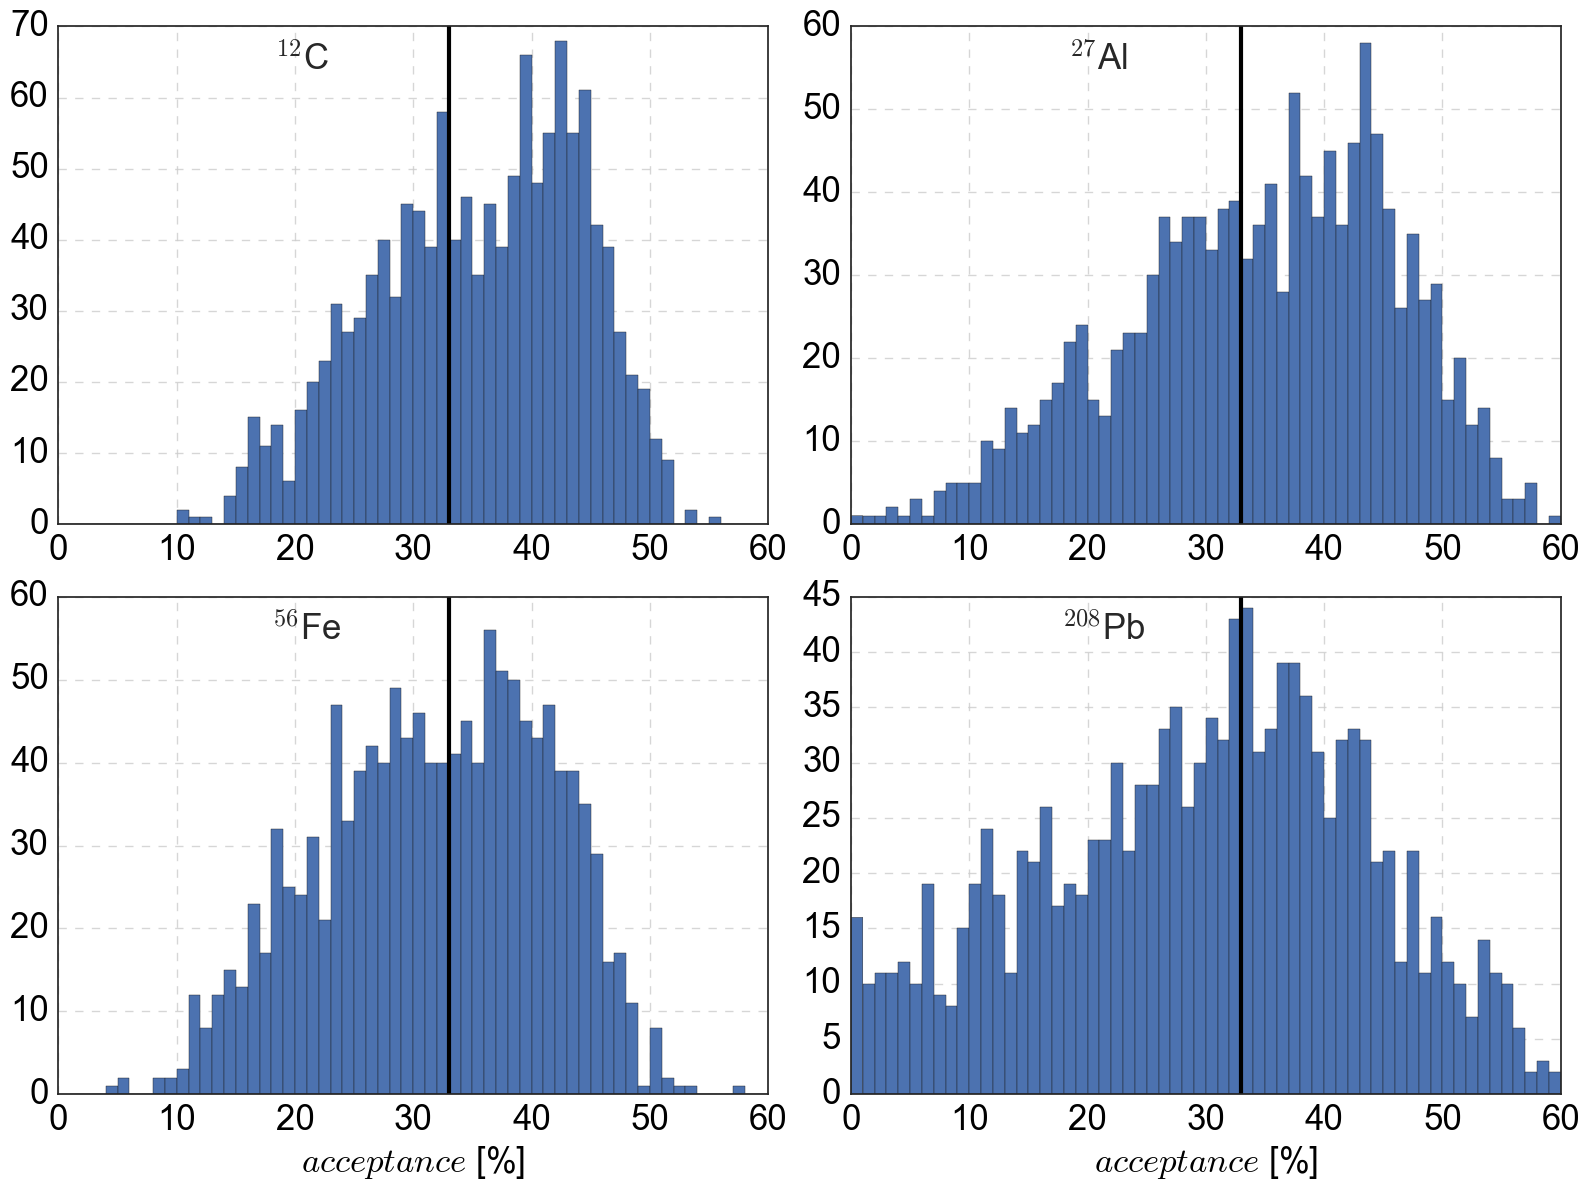

In [9]:
fig=plt.figure(figsize=(16,12))
bins=np.linspace(0,60,61)
for i,(A,target,target_name,cut_acceptance,Neep,Neepp) in enumerate(zip(As,targets,target_names,[33,33,33,33],[7598,2573,8558,2635],[266,88,227,45])):
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    ax=fig.add_subplot(2,2,i+1)
    h,bins,_=plt.hist(100*sims['Naccepted']/(20*(Neep+Neepp)),bins=bins)
    set_axes(ax,r'$acceptance$ [%]' if i>=2 else '',xlim=(0,60),do_add_grid=True)    
    ax.set_title(target_name+'\t\t\t',y=0.9,fontsize=25)
    plt.plot([cut_acceptance,cut_acceptance],ax.get_ylim(),'-',color='black',linewidth=3) #,label=r'$acceptance>%.0f'%cut_acceptance+'\%$ cut'
    ax.legend(fontsize=25,loc='best')
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/TmpPlots/previous_cut_acceptance.pdf')

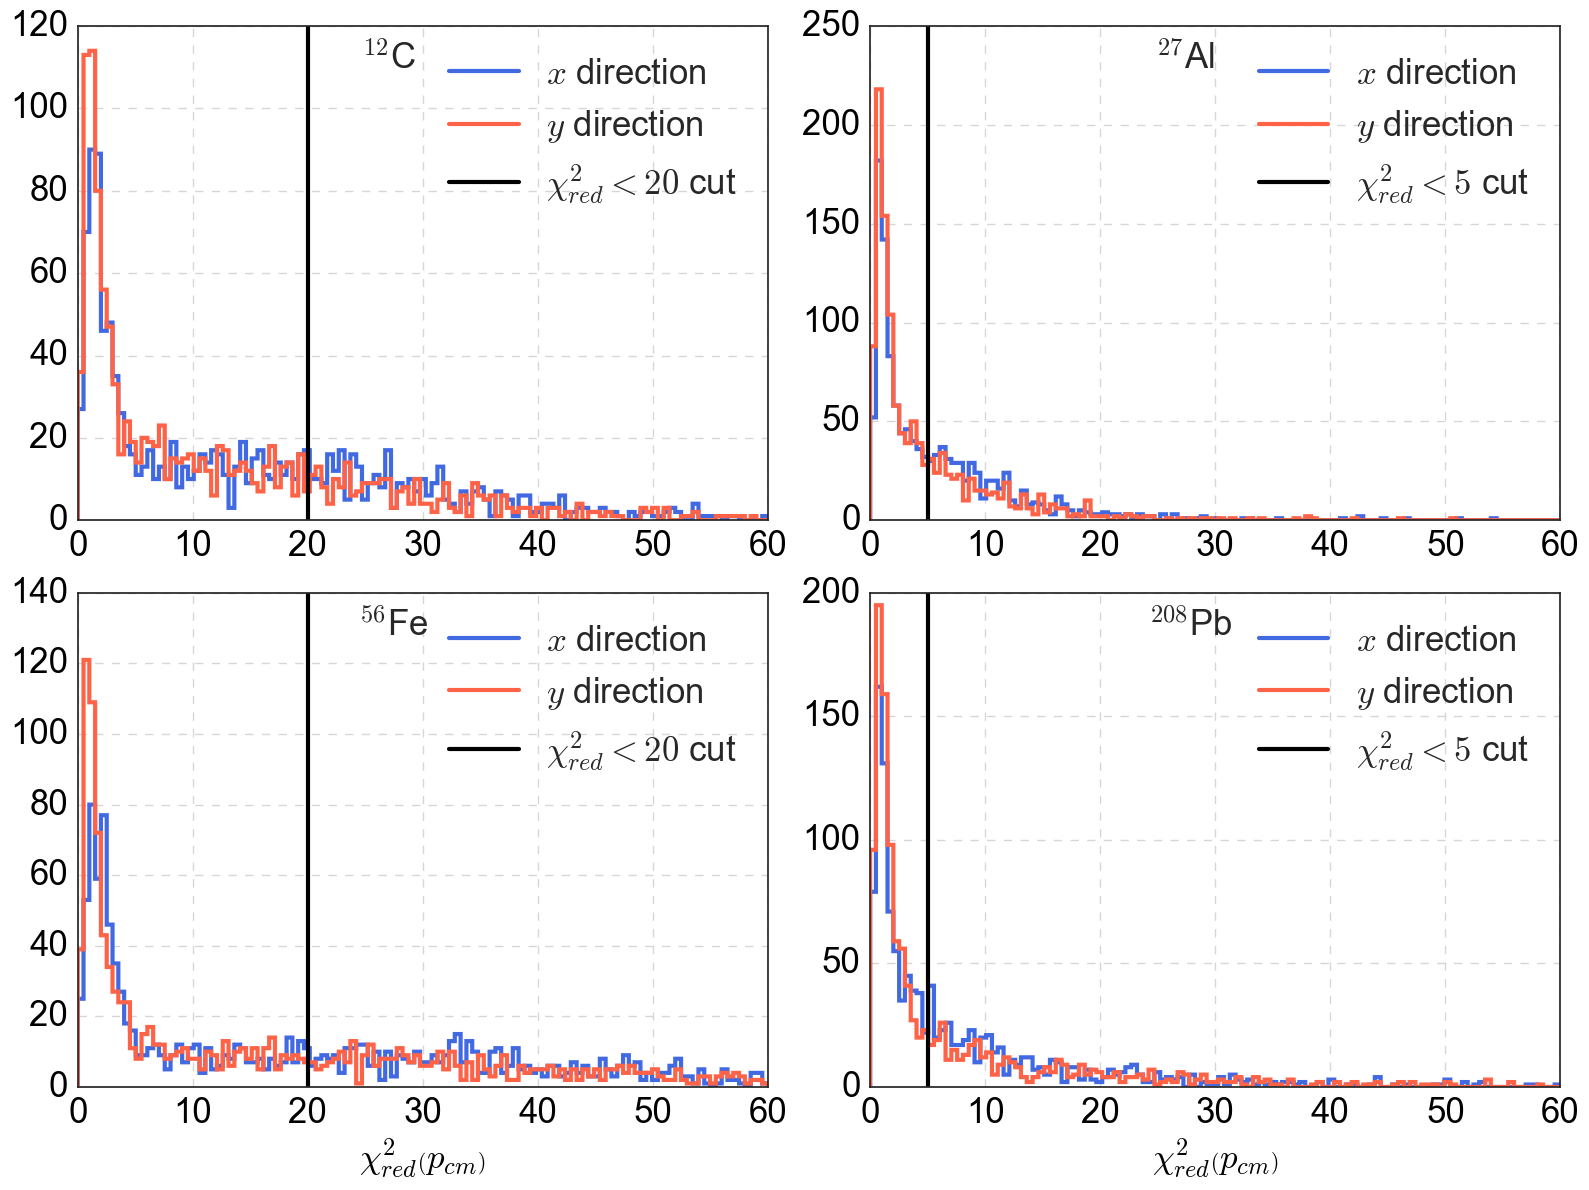

In [10]:
fig=plt.figure(figsize=(16,12))
bins=np.linspace(0,60,120)
for i,(A,target,target_name,cut_chi2red) in enumerate(zip(As,targets,target_names,cuts_chi2red)):#{
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    sims=sims[(sims['chi2red_x']<100)&(sims['chi2red_y']<100)]
    ax=fig.add_subplot(2,2,i+1)
    h,bins,_=plt.hist(sims['chi2red_x'],bins=bins,color='royalblue',histtype='step',linewidth=3)
    plt.plot([0,0],[0,0],linewidth=3,label='$x$ direction',color='royalblue')
    h,bins,_=plt.hist(sims['chi2red_y'],bins=bins,color='tomato',histtype='step',linewidth=3)
    plt.plot([0,0],[0,0],linewidth=3,label='$y$ direction',color='tomato')
    set_axes(ax,r'$\chi^2_{red} \left( p_{cm} \right)$' if i>=2 else '',xlim=(0,60),do_add_grid=True)    
    ax.set_title(target_name+'\t',y=0.9,fontsize=25)
    plt.plot([cut_chi2red,cut_chi2red],ax.get_ylim(),'-',color='black',linewidth=3,label=r'$\chi^2_{red}<%.0f$ cut'%cut_chi2red)
    ax.legend(fontsize=25,loc='best')
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/TmpPlots/cut_chi2.pdf')

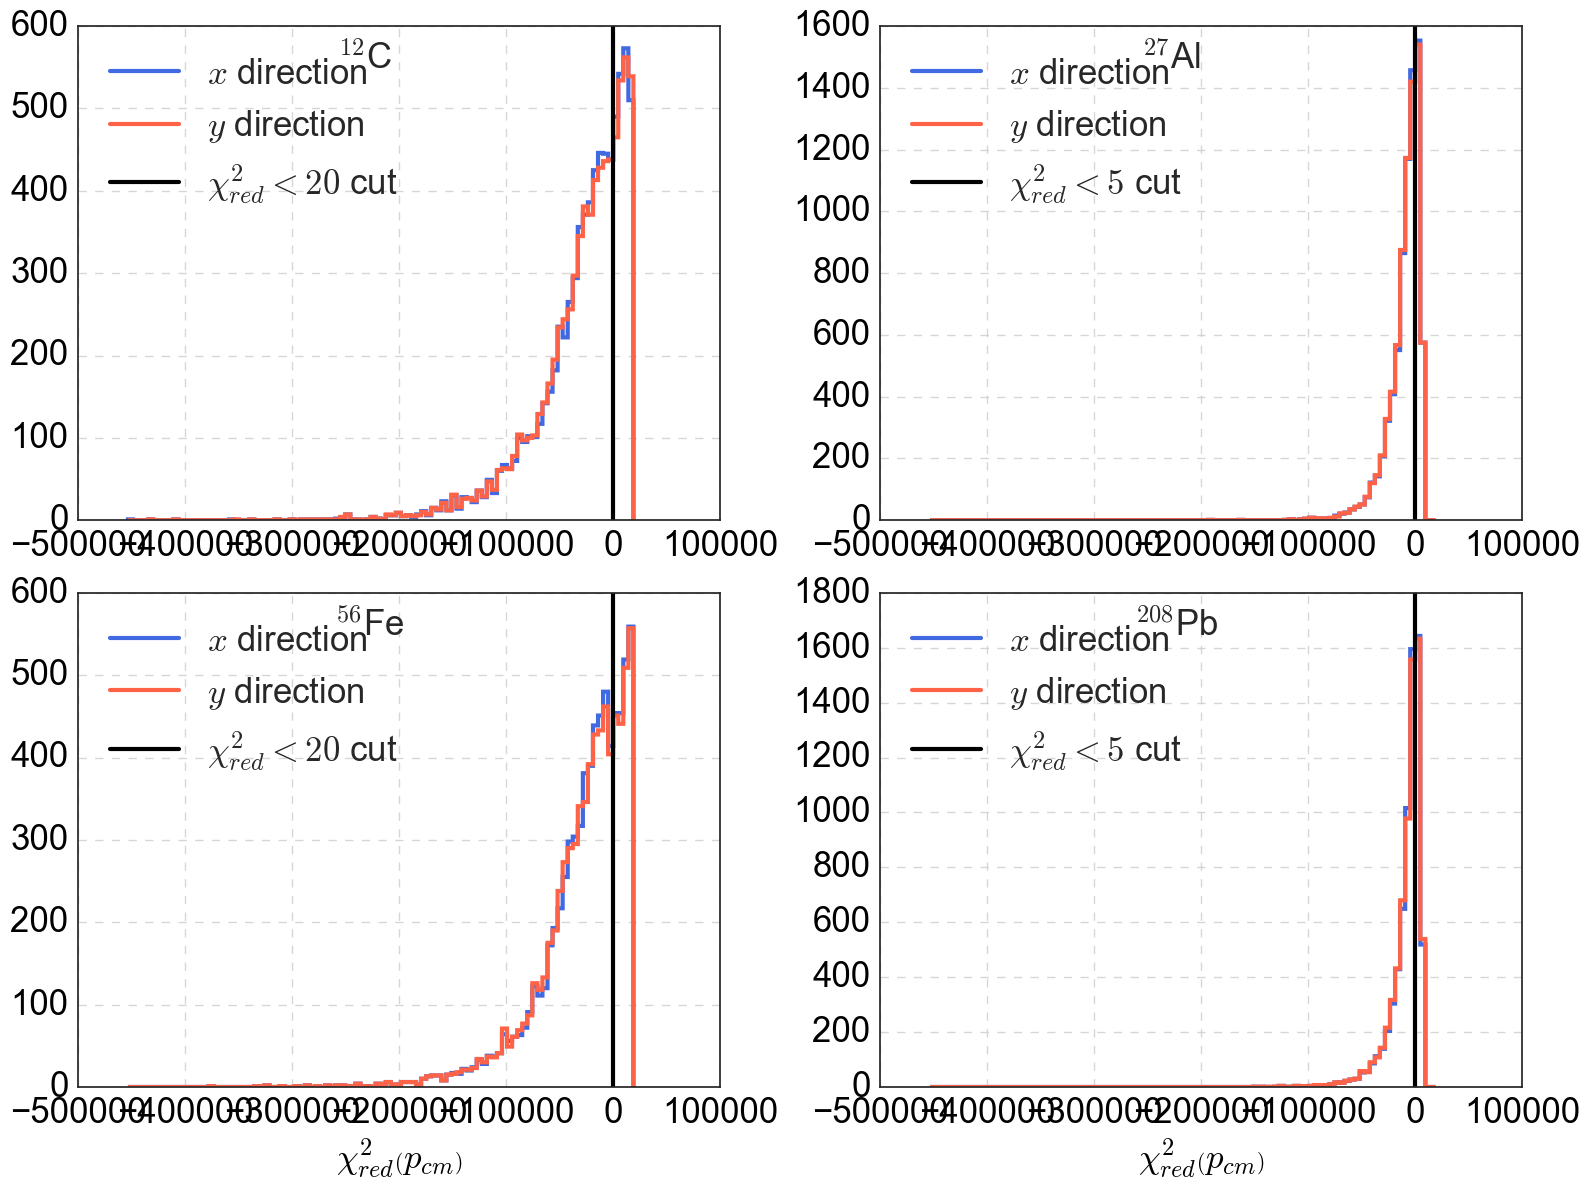

In [19]:
fig=plt.figure(figsize=(16,12))
bins=100 #np.linspace(0,60,120)
for i,(A,target,target_name,cut_chi2red) in enumerate(zip(As,targets,target_names,cuts_chi2red)):#{
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
#     sims=sims[(sims['chi2red_x']<100)&(sims['chi2red_y']<100)]
    ax=fig.add_subplot(2,2,i+1)
    h,bins,_=plt.hist(sims['minNLogLikelihood_x'],bins=bins,color='royalblue',histtype='step',linewidth=3)
    plt.plot([0,0],[0,0],linewidth=3,label='$x$ direction',color='royalblue')
    h,bins,_=plt.hist(sims['minNLogLikelihood_y'],bins=bins,color='tomato',histtype='step',linewidth=3)
    plt.plot([0,0],[0,0],linewidth=3,label='$y$ direction',color='tomato')
    set_axes(ax,r'$\chi^2_{red} \left( p_{cm} \right)$' if i>=2 else ''
#              ,xlim=(0,60)
             ,do_add_grid=True)    
    ax.set_title(target_name+'\t',y=0.9,fontsize=25)
    plt.plot([cut_chi2red,cut_chi2red],ax.get_ylim(),'-',color='black'
             ,linewidth=3,label=r'$\chi^2_{red}<%.0f$ cut'%cut_chi2red)
    ax.legend(fontsize=25,loc='best')
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/TmpPlots/minNll.pdf')



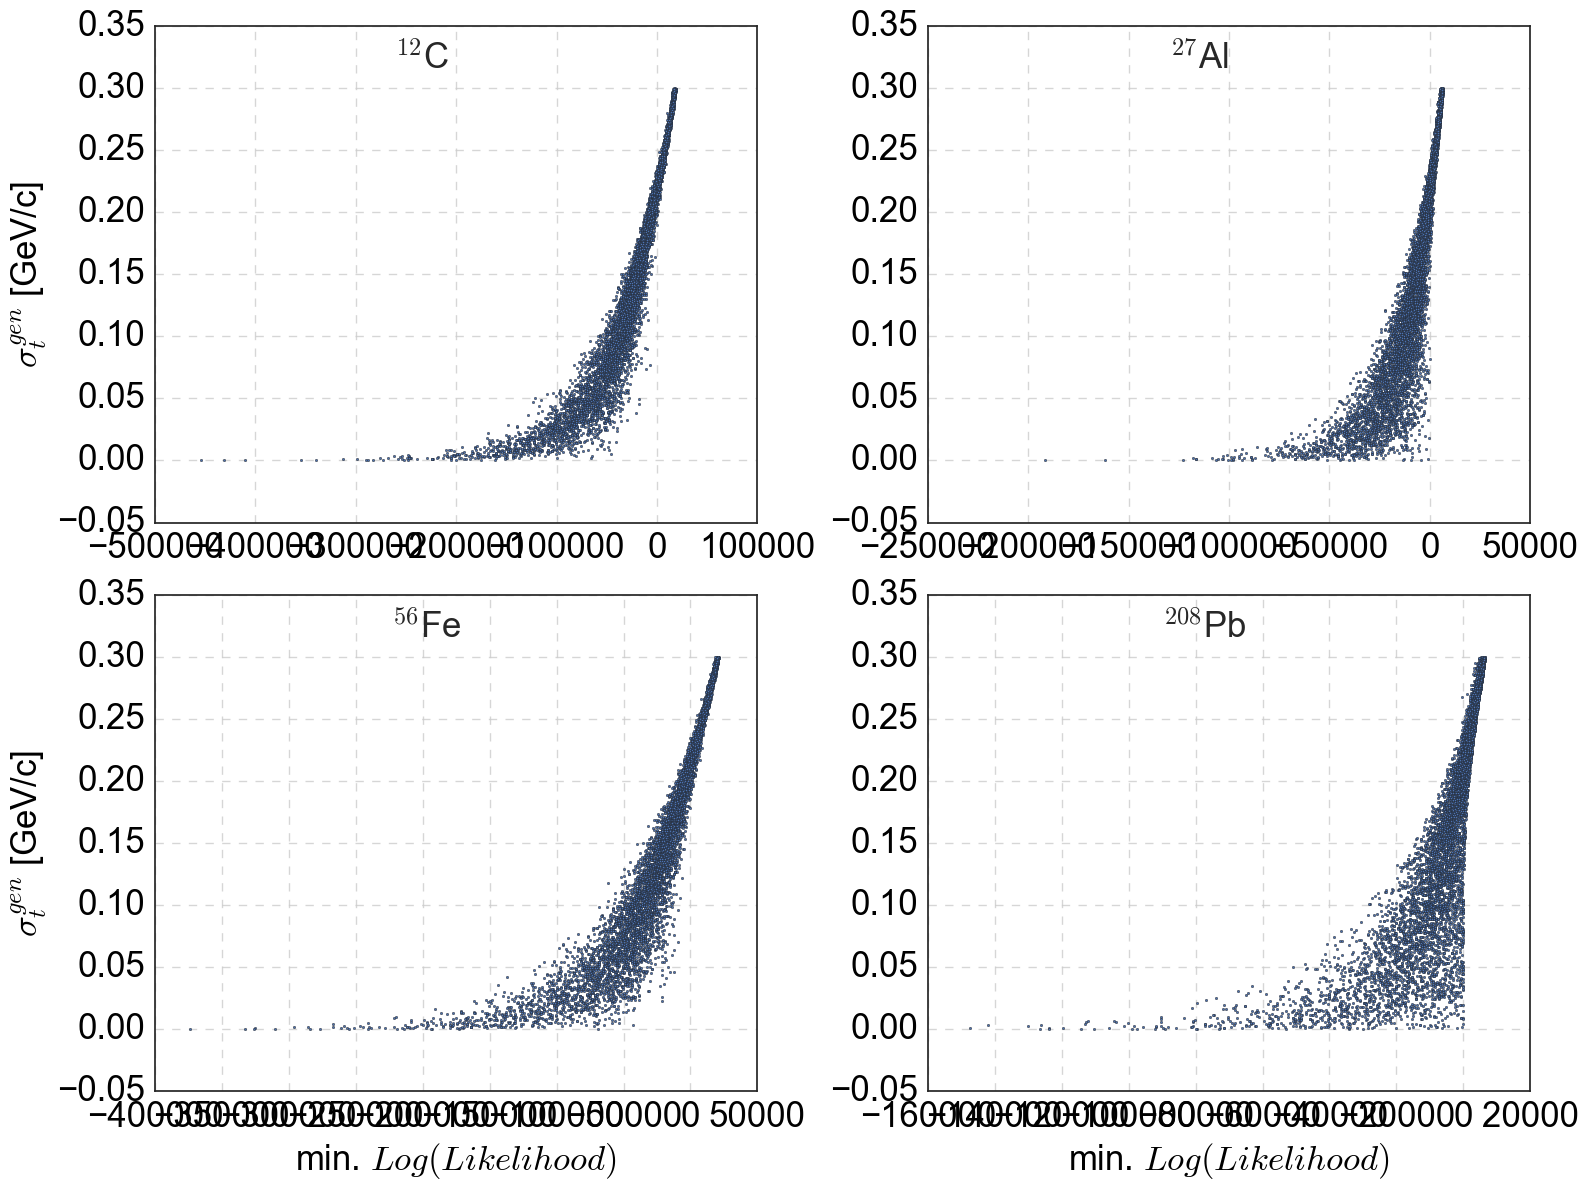

In [38]:
fig=plt.figure(figsize=(16,12))
bins=np.linspace(0,60,61)
for i,(A,target,target_name,Neep,Neepp) in enumerate(zip(As,targets,target_names,[7598,2573,8558,2635],[266,88,227,45])):
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    ax=fig.add_subplot(2,2,i+1)
    sims_large_st = sims[sims['gen_Sigma_t']>0.1]
#     plt.scatter(sims_large_st['minNLogLikelihood_x'],100*sims_large_st['Naccepted']/(20*(Neep+Neepp)),s=3)
    plt.scatter(sims['minNLogLikelihood_x'],sims['gen_Sigma_t'],s=3)
    set_axes(ax,r'min. $Log(Likelihood)$' if i>=2 else ''
             ,r'$\sigma_t^{gen}$ [GeV/c]' if i==0 or i==2 else ''
             ,do_add_grid=True)    
    ax.set_title(target_name+'\t',y=0.9,fontsize=25)
plt.tight_layout()
# plt.savefig('/Users/erezcohen/Desktop/TmpPlots/acceptance_vs_minNll.pdf')

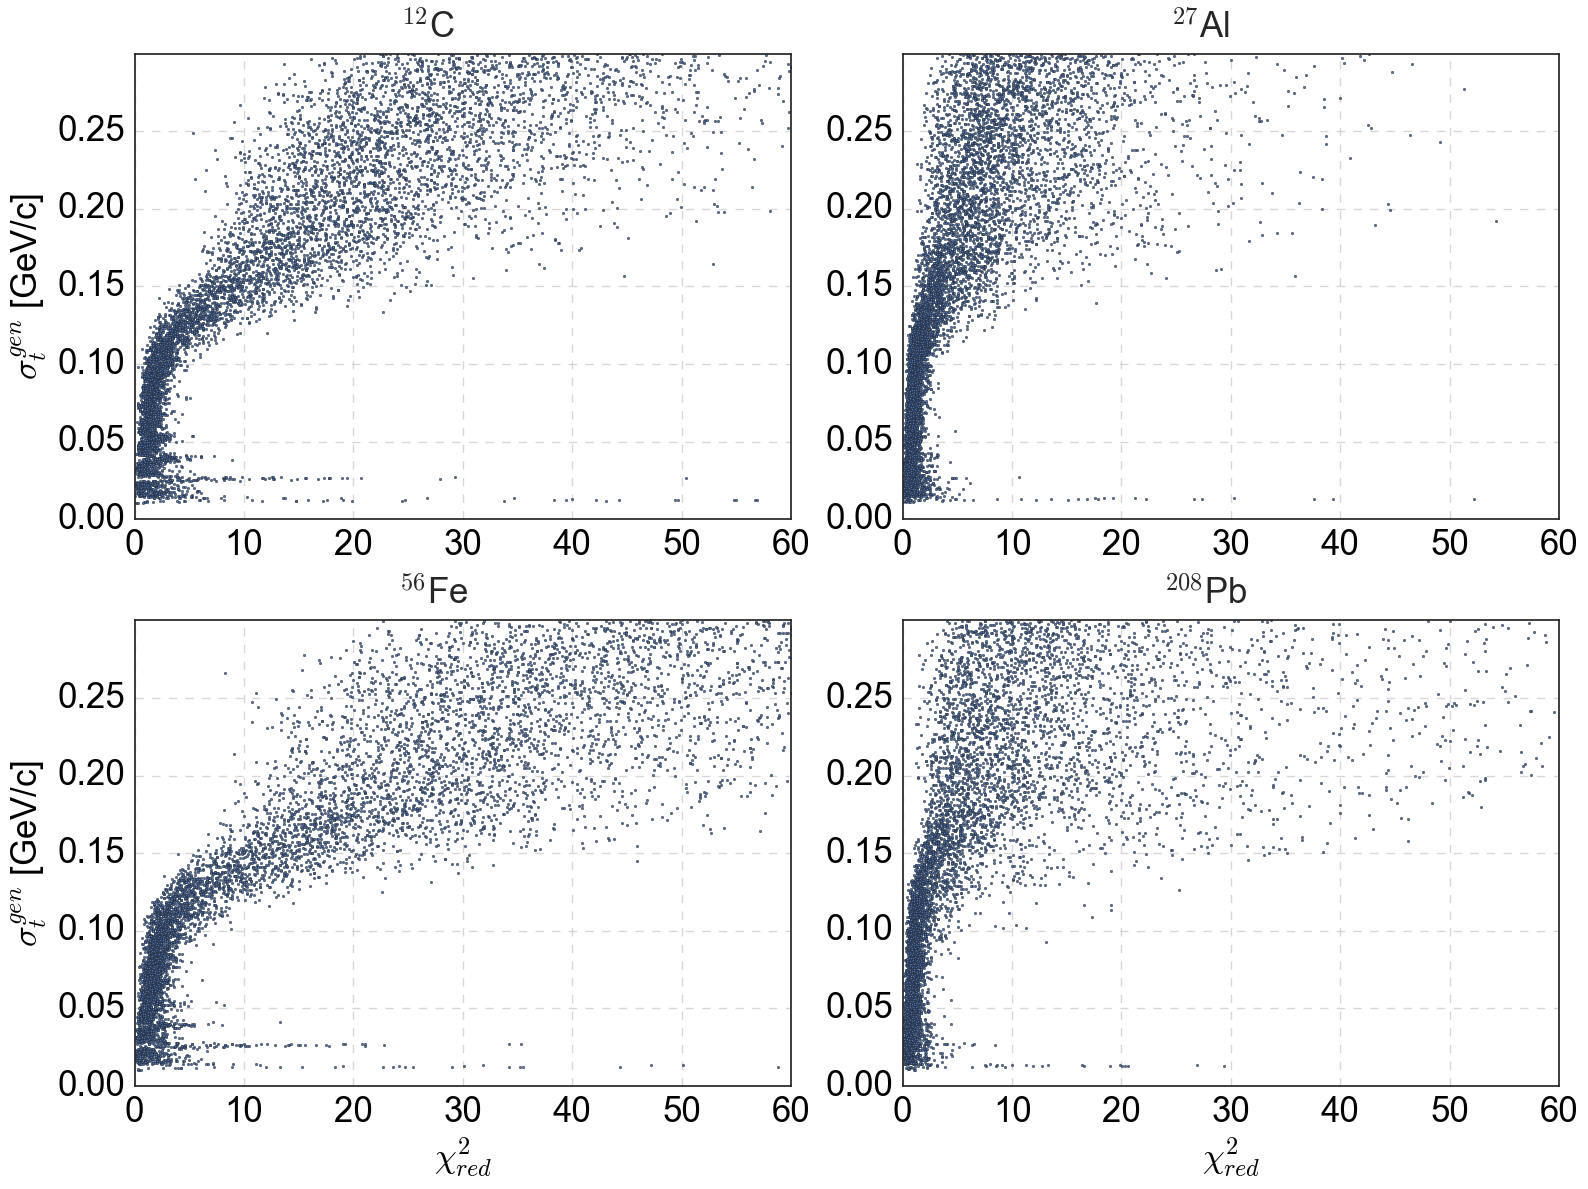

In [41]:
fig=plt.figure(figsize=(16,12))
bins=np.linspace(0,60,61)
for i,(A,target,target_name,Neep,Neepp) in enumerate(zip(As,targets,target_names,[7598,2573,8558,2635],[266,88,227,45])):
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    ax=fig.add_subplot(2,2,i+1)
    sims_large_st = sims[sims['gen_Sigma_t']>0.1]
#     plt.scatter(sims_large_st['chi2red_x'],100*sims_large_st['Naccepted']/(20*(Neep+Neepp)),s=3)
    plt.scatter(sims['chi2red_x'],sims['gen_Sigma_t'],s=3)
    set_axes(ax,r'$\chi^2_{red}$' if i>=2 else ''
             ,r'$\sigma_t^{gen}$ [GeV/c]' if i==0 or i==2 else '',xlim=(0,60),ylim=(0.0,0.3)
             ,do_add_grid=True)    
    ax.set_title(target_name+'\t',y=1.02,fontsize=25)
plt.tight_layout()
# plt.savefig('/Users/erezcohen/Desktop/TmpPlots/acceptance_vs_minNll.pdf')

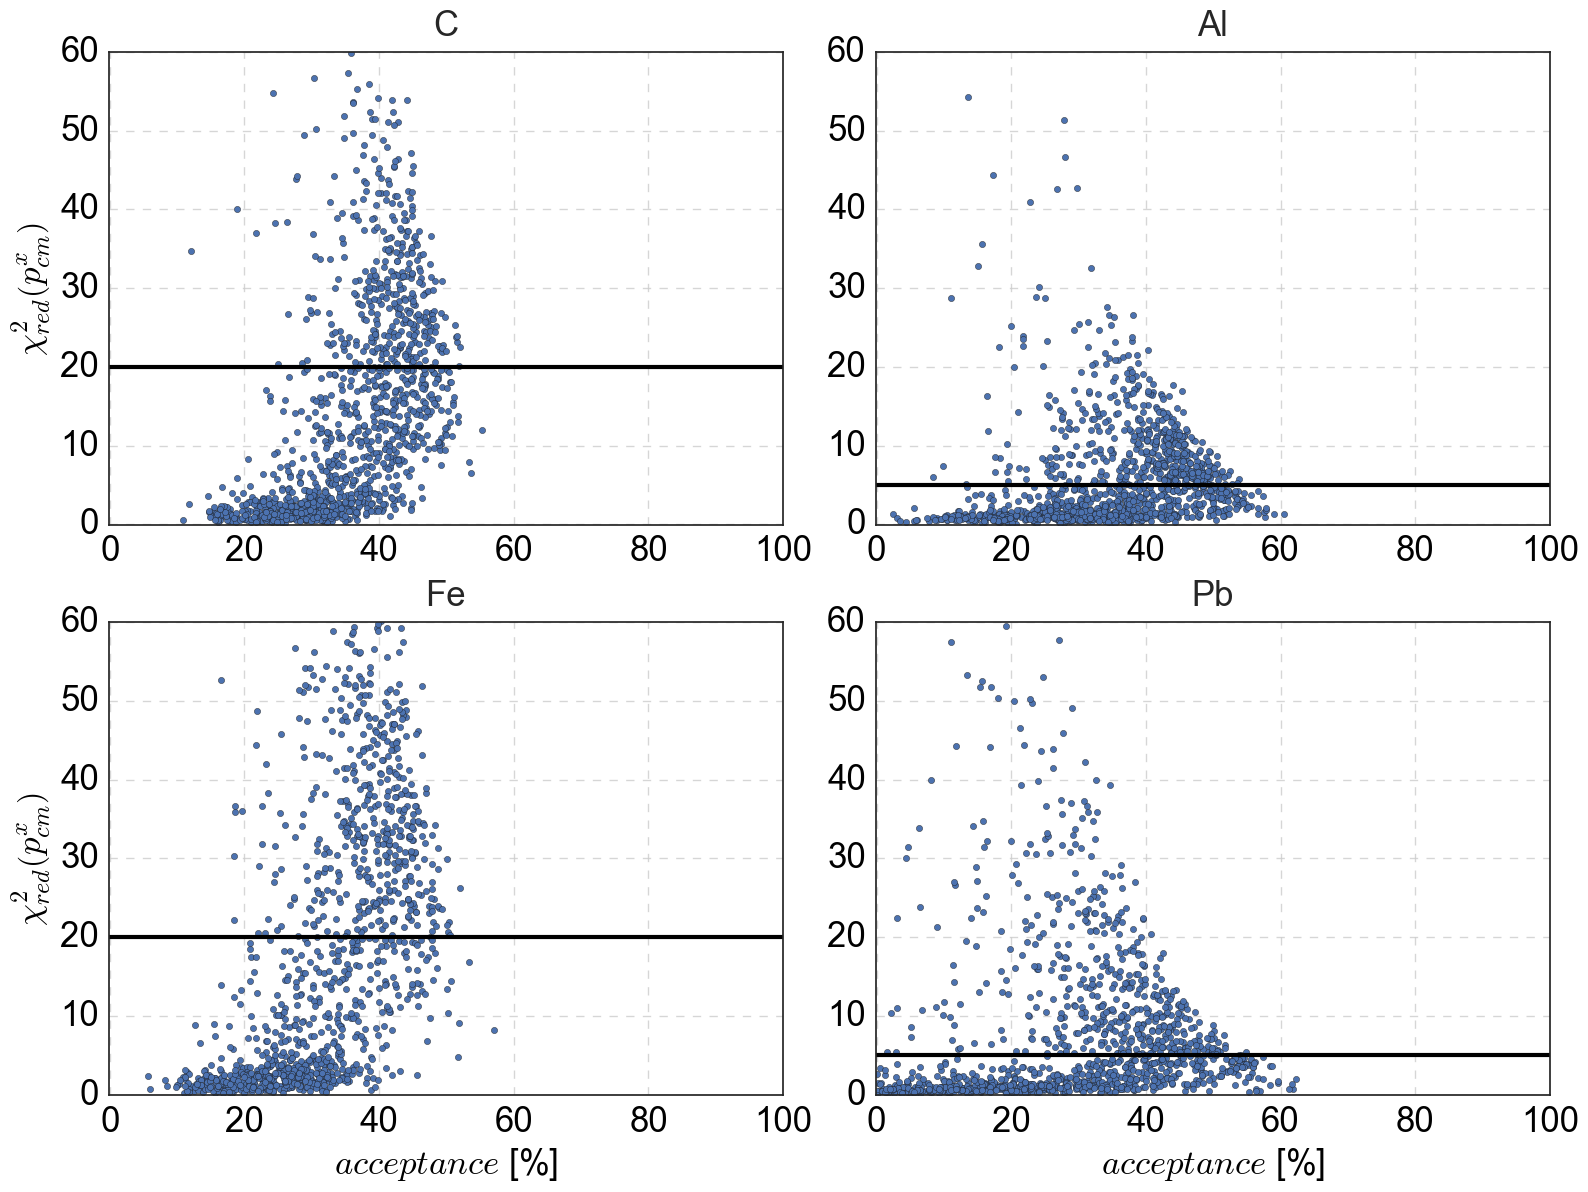

In [13]:
fig=plt.figure(figsize=(16,12))
for i,(A,target,cut_chi2red,Neep,Neepp) in enumerate(zip(As,targets,cuts_chi2red,[7598,2573,8558,2635],[266,88,227,45])):
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    ax=fig.add_subplot(2,2,i+1)
    plt.scatter(100*sims['Naccepted']/(20*(Neep+Neepp)),sims['chi2red_x'])    
#     sims_small_st = sims[sims['gen_Sigma_t']<0.1]
#     plt.scatter(sims_small_st['gen_MeanZ'],sims_small_st['chi2red_x'],color='green',s=3,label='r$\sigma_t^{gen.}<0.1$ GeV/c')
#     sims_large_st = sims[sims['gen_Sigma_t']>0.1]
#     plt.scatter(sims_large_st['gen_MeanZ'],sims_large_st['chi2red_x'],color='red',s=3,label='r$\sigma_t^{gen.}>0.1$ GeV/c')
    set_axes(ax,r'$acceptance$ [%]' if i>=2 else ''
             ,r'$\chi^2_{red} \left( p_{cm}^x \right)$' if i==0 or i==2 else ''
             ,title=target,xlim=(-0.15,100),ylim=(-0.1,60),do_add_grid=True)    
    plt.plot(ax.get_xlim(),[cut_chi2red,cut_chi2red],'-',color='black',linewidth=3,label=r'$\chi^2_{red}<%.0f$ cut'%cut_chi2red)

plt.tight_layout()

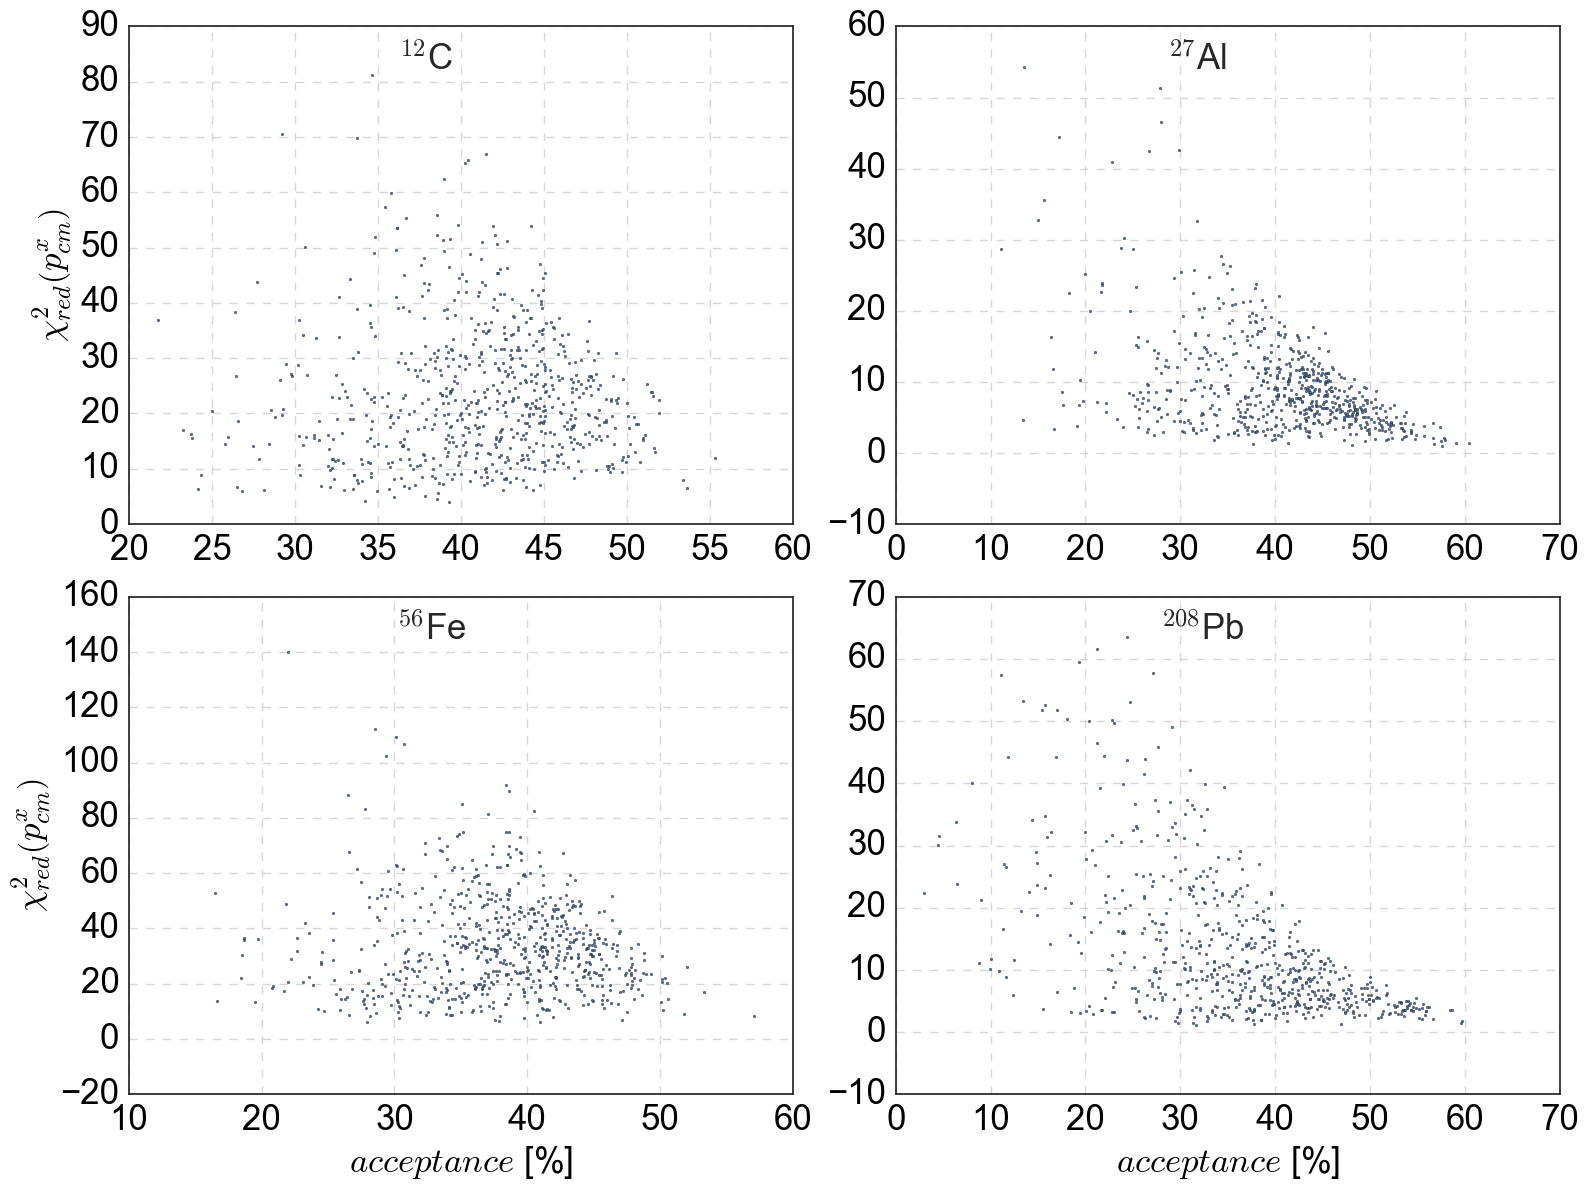

In [14]:
fig=plt.figure(figsize=(16,12))
bins=np.linspace(0,60,61)
for i,(A,target,target_name,cut_chi2red,Neep,Neepp) in enumerate(zip(As,targets,target_names,cuts_chi2red,[7598,2573,8558,2635],[266,88,227,45])):
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    ax=fig.add_subplot(2,2,i+1)
    sims_large_st = sims[sims['gen_Sigma_t']>0.14]
    plt.scatter(100*sims_large_st['Naccepted']/(20*(Neep+Neepp)),sims_large_st['chi2red_x'],s=3)
#     plot_2d_hist(100*sims_large_st['Naccepted']/(20*(Neep+Neepp)),sims_large_st['chi2red_x'],bins=50,ax=ax)
    set_axes(ax,r'$acceptance$ [%]' if i>=2 else ''
             ,r'$\chi^2_{red} \left( p_{cm}^x \right)$' if i==0 or i==2 else ''
#              ,xlim=(-0.15,100)
#              ,ylim=(-0.1,60)
             ,do_add_grid=True)    
#     plt.plot(ax.get_xlim(),[cut_chi2red,cut_chi2red],'-',color='black',linewidth=3,label=r'$\chi^2_{red}<%.0f$ cut'%cut_chi2red)
    ax.set_title(target_name+'\t',y=0.9,fontsize=25)
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/acceptance_vs_chi2.pdf')

In [15]:
def find_x_poly(poly,y0,xmin=0,xmax=0.3):
    p = np.poly1d(poly)
    roots = (p - y0).roots
    x_poly=-1
    for root in roots:
        if xmin<root and root<xmax:
            x_poly = root
    return x_poly

In [16]:
def plot_cm_direction(simulations_results=None
                      ,Fiducials='PrecFiducials'
                      ,extraname=""
                      ,ax=None,A=12
                      ,poly_degree=3
                      ,confidence_interval = 0.68
                      ,direction='x',colors=['blue','royalblue'],s=50
                      ,debug=0):

    gen,rec = simulations_results['gen_Sigma_t'],simulations_results['rec_sigma_'+direction]
    plt.scatter(gen,rec,color=colors[1],label='generated vs. reconstructed',s=s)
    # fit a polynomial of order 2
    popt,cov = np.polyfit( gen,rec , poly_degree , cov=True)
    perr = np.sqrt(np.diag(cov))
    if debug: print "popt:",popt,"\nperr:",perr
    
    x = np.linspace(np.min(ax.get_xlim()),np.max(ax.get_xlim()),1000)
    poly = np.poly1d(popt)
    ax.plot(x,poly(x),'-',color='black',linewidth=2,label='best fit')    
    
    # Convert to percentile point of the normal distribution [https://en.wikipedia.org/wiki/Standard_score]
    pp = (1. + confidence_interval) / 2.
    # Convert to number of standard deviations.
    nstd = stats.norm.ppf(pp)
    
    # Add nstd standard deviations to parameters to obtain the upper confidence interval
    poly_up = np.poly1d(popt + nstd * perr)
    ax.plot(x,poly_up(x),'-',color='gray',linewidth=2)
    poly_dw = np.poly1d(popt - nstd * perr)
    ax.plot(x,poly_dw(x),'-',color='gray',linewidth=2)
    
    cm_pars = cm_parameters[Fiducials]        
    cm_pars_target = cm_pars[cm_pars['A']==A]
    index = cm_pars[cm_pars['A']==A].index
    # reconstructed \sigma in data
    if debug:  print cm_pars_target
    sigma_meas, sigma_meas_err = float(cm_pars_target['sigma_'+direction+'_before_acc_corr']), float(cm_pars_target['sigma_'+direction+'_before_acc_corr_err'])
    y =  np.ones(len(x)) * sigma_meas
    yErr =  np.ones(len(x)) * sigma_meas_err

    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_value =  find_x_poly(poly , sigma_meas)
    label_corr = '$%.3f$'%(corr_value)
    plt.plot( np.linspace(np.min(ax.get_xlim()),corr_value,1000) , y , color=colors[1],label='measured: $%.3f\\pm%.3f$'%(sigma_meas, sigma_meas_err))
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # only statistical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_stat = find_x_poly(poly,sigma_meas+sigma_meas_err)
    x_poly_dw_stat = find_x_poly(poly,sigma_meas-sigma_meas_err)
    corr_val_up_err_stat = x_poly_up_stat - corr_value
    corr_val_dw_err_stat = corr_value - x_poly_dw_stat
    label_unc_stat = '$(^{+%.0f}_{-%.0f})_{stat.}$'%(1000*corr_val_up_err_stat,1000*corr_val_dw_err_stat)
    
    plt.plot( [x_poly_up_stat,x_poly_up_stat] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='black' ,linestyle='--')
    plt.plot( [x_poly_dw_stat,x_poly_dw_stat] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='black' ,linestyle='--' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 

    # systematical uncertainty
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    x_poly_up_sys = find_x_poly(poly_dw,sigma_meas+sigma_meas_err)
    x_poly_dw_sys = find_x_poly(poly_up,sigma_meas-sigma_meas_err)
    corr_val_up_err_sys = x_poly_up_sys - x_poly_up_stat
    corr_val_dw_err_sys = x_poly_dw_stat - x_poly_dw_sys
    label_unc_sys = '$(^{+%.0f}_{-%.0f})_{sys.}$'%(1000*corr_val_up_err_sys,1000*corr_val_dw_err_sys)

    if debug:  print "plt.plot( np.linspace(np.min(ax.get_xlim()),corr_value,1000)..."   
    # projection of the measured uncertainties
    plt.plot( np.linspace(np.min(ax.get_xlim()),x_poly_up_sys,1000) , y+yErr , color=colors[0],linestyle='-',alpha=0.35)
    plt.plot( np.linspace(np.min(ax.get_xlim()),x_poly_dw_sys,1000) , y-yErr , color=colors[0],linestyle='-',alpha=0.35)

    # projection of the systematical uncertainties
    plt.plot( [x_poly_up_sys,x_poly_up_sys] , [np.min(ax.get_ylim()),sigma_meas+sigma_meas_err] , color='grey' ,linestyle='-')
    plt.plot( [x_poly_dw_sys,x_poly_dw_sys] , [np.min(ax.get_ylim()),sigma_meas-sigma_meas_err] , color='grey' ,linestyle='-' )
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    if debug:  print "plugging",'sigma_'+direction+'_corrected'+extraname
    
    # corrected value
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
    corr_val_up_err_tot = np.sqrt(np.square(corr_val_up_err_stat) + np.square(corr_val_up_err_sys))
    corr_val_dw_err_tot = np.sqrt(np.square(corr_val_dw_err_stat) + np.square(corr_val_dw_err_sys))
    
    plt.plot( [corr_value,corr_value] , [np.min(ax.get_ylim()),sigma_meas] , color=colors[0]
             ,label='corrected:'+label_corr+label_unc_stat+label_unc_sys)
    # --- - - -- -- - -- - -- -- - -- -- -- - -- --- 
        
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected'+extraname,corr_value)
    
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_stat'+extraname,corr_val_up_err_stat)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_stat'+extraname,corr_val_dw_err_stat)
             
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_sys'+extraname,corr_val_up_err_sys)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_sys'+extraname,corr_val_dw_err_sys)

    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_up_err_tot'+extraname,corr_val_up_err_tot)
    cm_parameters_with_correction[Fiducials].set_value(index,'sigma_'+direction+'_corrected_dw_err_tot'+extraname,corr_val_dw_err_tot)             
             
    set_axes(ax,'gen. $\\sigma$ [GeV/c]','rec. $\\sigma_'+direction+'$ [GeV/c]'    
             , xticks=[0.05,0.1,0.15,0.2,0.25] , yticks=[0.05,0.1,0.15,0.2,0.25] , do_add_grid=True 
             ,title = cm_pars_target['target'].to_string(index=False) + ', $'+direction+'-direction$ ('+Fiducials+')')

    ax.legend(loc='upper left',fontsize=20,scatterpoints=3,markerscale=2)
    ax.set_xlim(0.02,0.3);ax.set_ylim(0.02,0.3);
    return corr_value, corr_val_up_err_tot , corr_val_dw_err_tot

In [34]:
cut_chi2red = 10
# extraname='cut_chi2_%.1f_%.1f_%.1f_%.1f'%(cuts_chi2red[0],cuts_chi2red[1],cuts_chi2red[2],cuts_chi2red[3])
extraname='cut_chi2_%.1f'%cuts_chi2red
# cut_Pval = 1e-3
# extraname='cut_Pval_%g'%cut_Pval
# cut_minNll_max = -0e3
# extraname='cut_minNll_max_%g'%cut_minNll_max
print "extraname:",extraname

extraname: cut_chi2_15.0


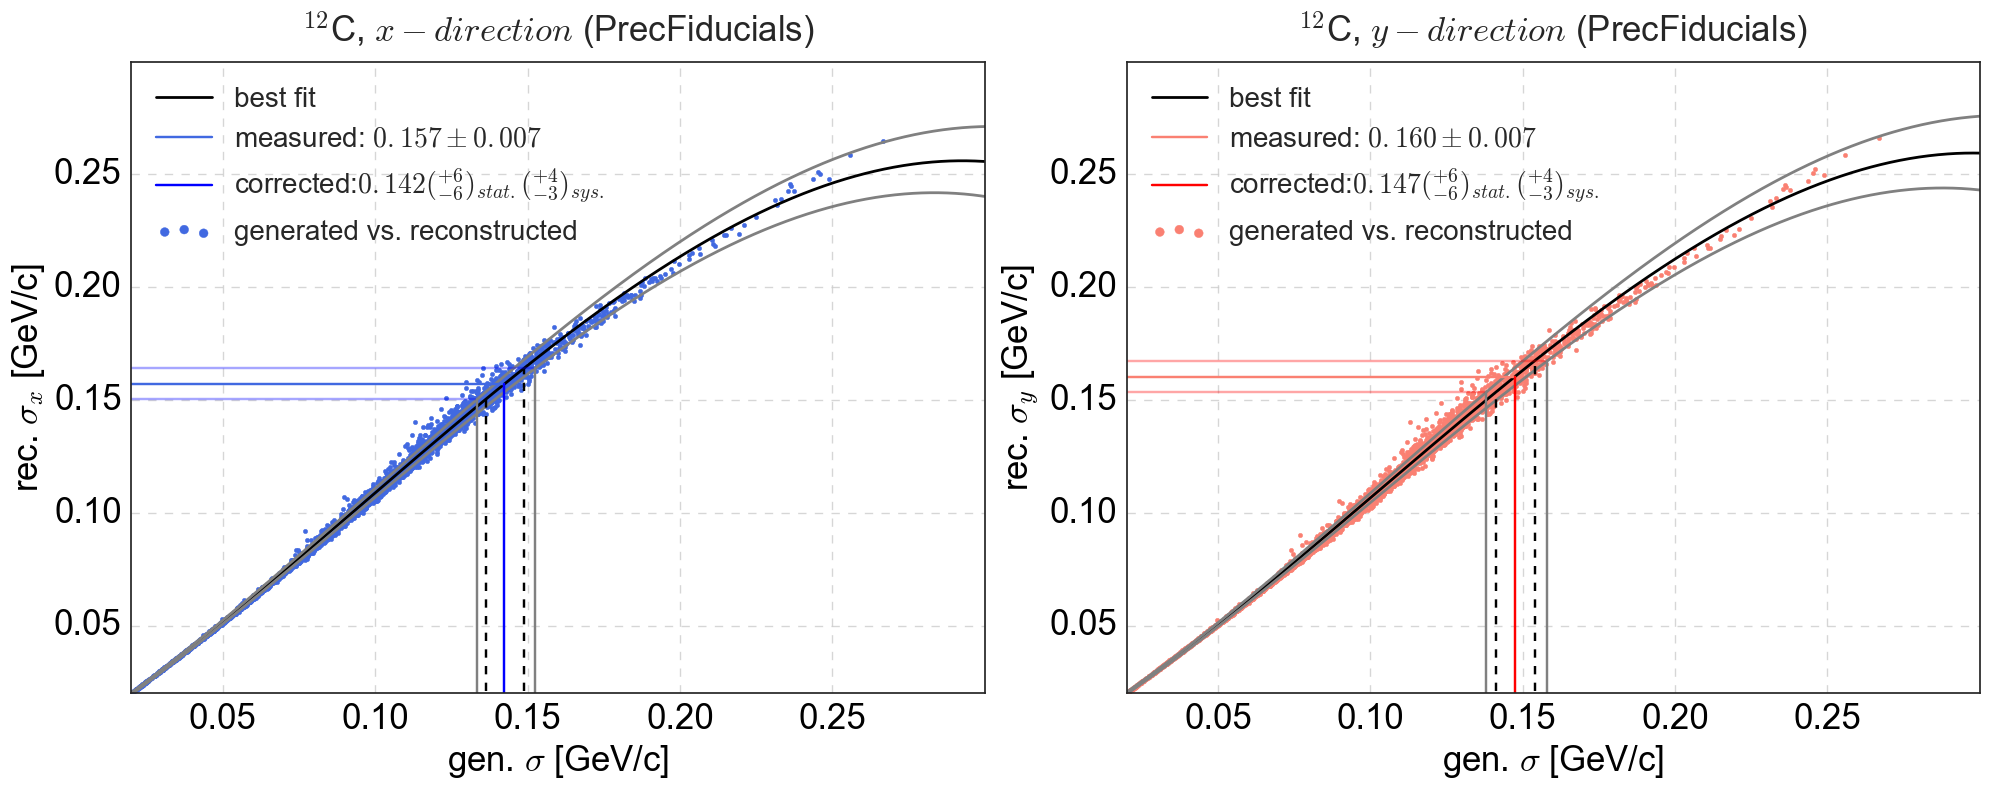

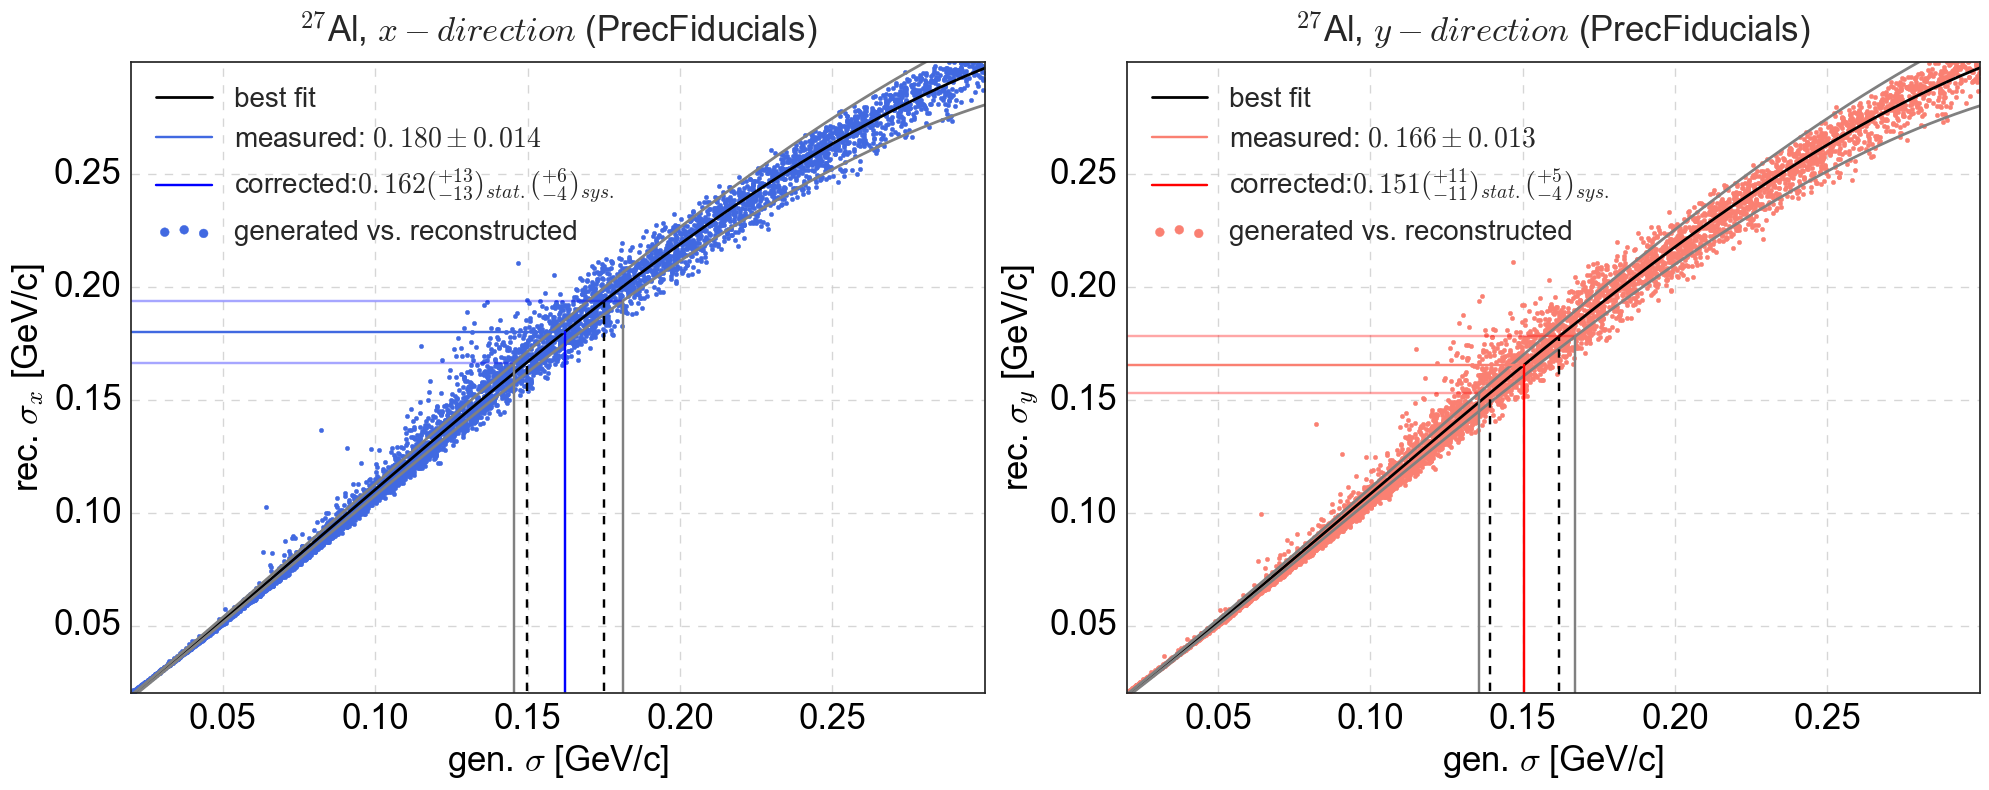

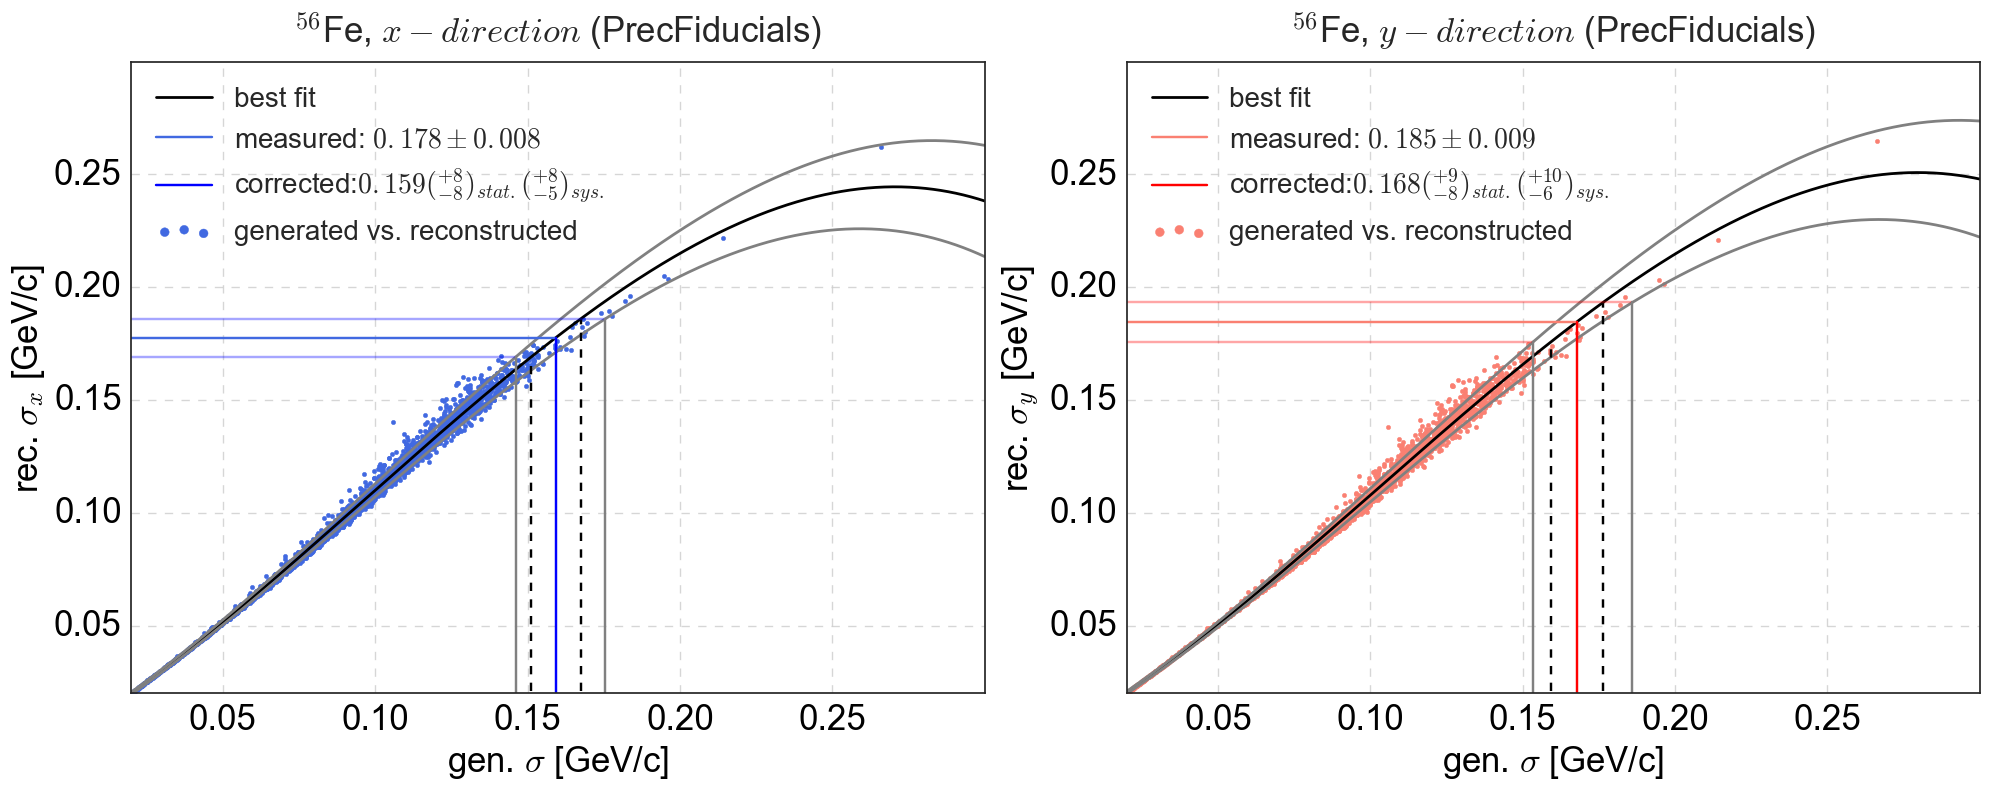

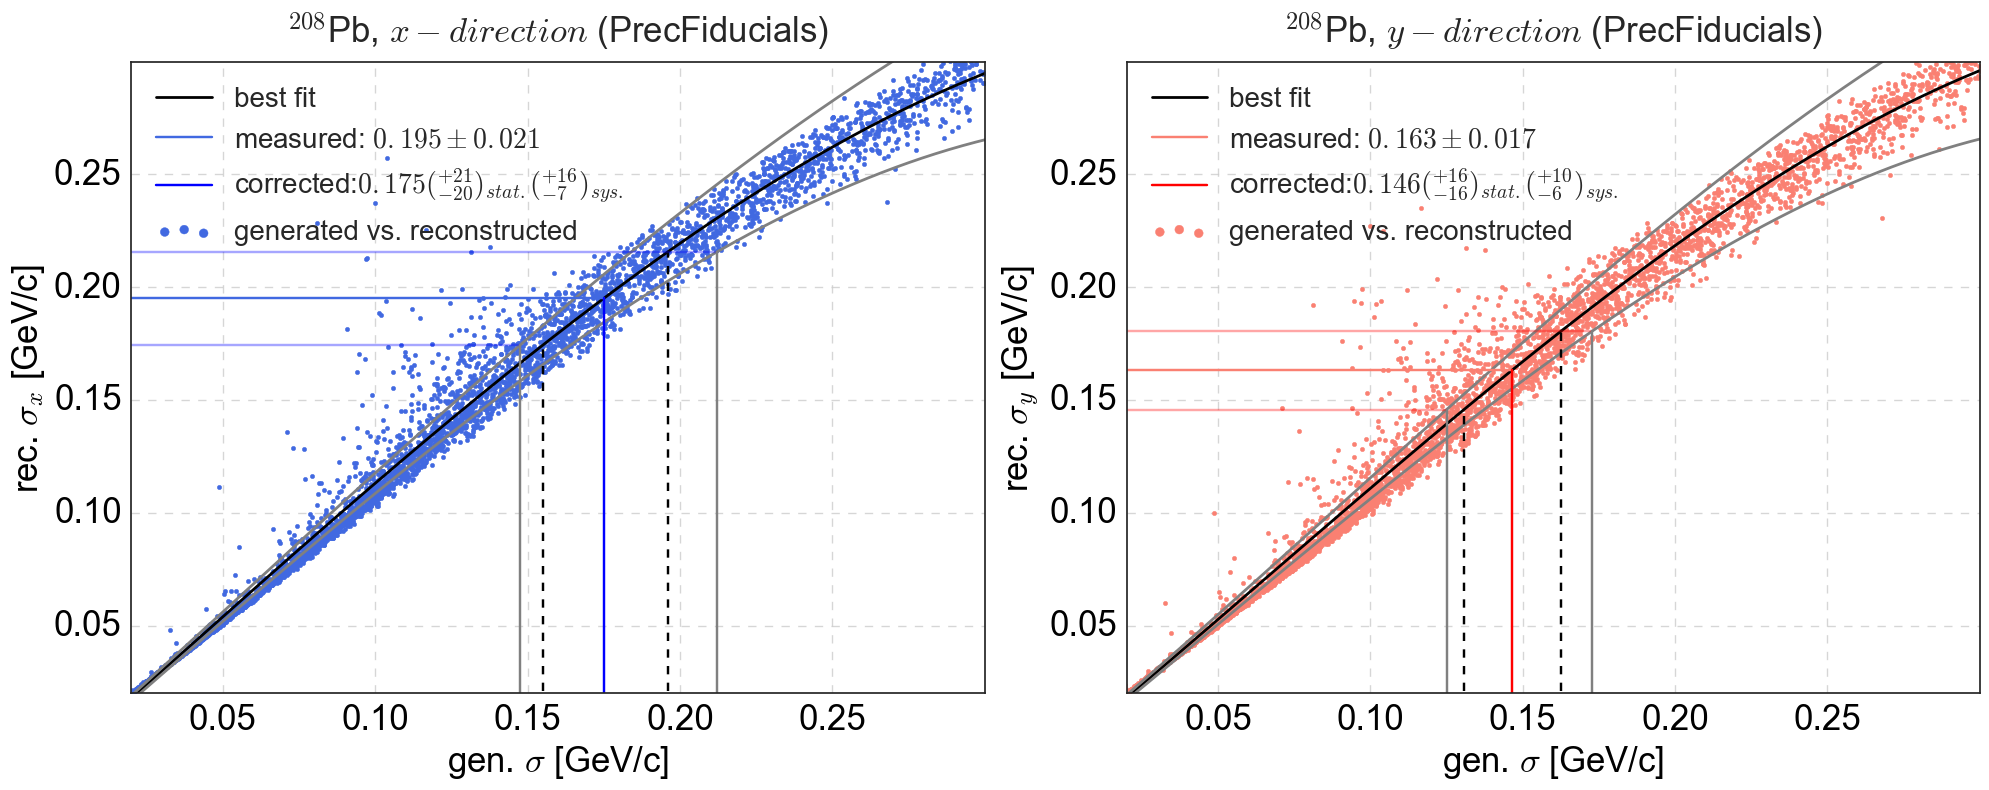

In [35]:
poly_degree = 3 # fit polynomial degree
confidence_interval = 0.68 # band around fit
for i,(A,target) in enumerate(zip(As,targets)):#{
    test_name = "simulations_"+target
    sims=simulation_results[test_name]        
#     sims['Pval_x'] = 1 - stats.chi2.cdf(sims['chi2red_x'], 1)
#     sims['Pval_y'] = 1 - stats.chi2.cdf(sims['chi2red_y'], 1)
    good_results = sims[
        (sims['gen_SigmaZ']>0)&(sims['rec_sigma_x']>0)&(sims['rec_sigma_y']>0)&(sims['rec_sigma_z']>0)
        &(sims['rec_mean_x']>-0.9)&(sims['rec_mean_y']>-0.9)&(sims['rec_mean_x']>-0.9)&
        (sims['chi2red_x']<cut_chi2red) &(sims['chi2red_y']<cut_chi2red)
#         (sims['Pval_x']>cut_Pval) &(sims['Pval_y']>cut_Pval) 
#         (sims['minNLogLikelihood_x']<cut_minNll_max)
                       ]
    fig=plt.figure(figsize=(20,8))    
    ax=fig.add_subplot(1,2,1)    
    plot_cm_direction(simulations_results=good_results, ax=ax,s=10,extraname=extraname
                                ,poly_degree=poly_degree,confidence_interval=confidence_interval                                                                                           
                                ,A=A,direction='x'                                                                                           
                                ,colors=['blue','royalblue']);
    ax=fig.add_subplot(1,2,2)    
    corr_sy = plot_cm_direction(simulations_results=good_results, ax=ax,s=10,extraname=extraname
                                ,poly_degree=poly_degree,confidence_interval=confidence_interval                                
                                ,A=A,direction='y'
                                ,colors=['red','salmon']);                            
    plt.tight_layout()   

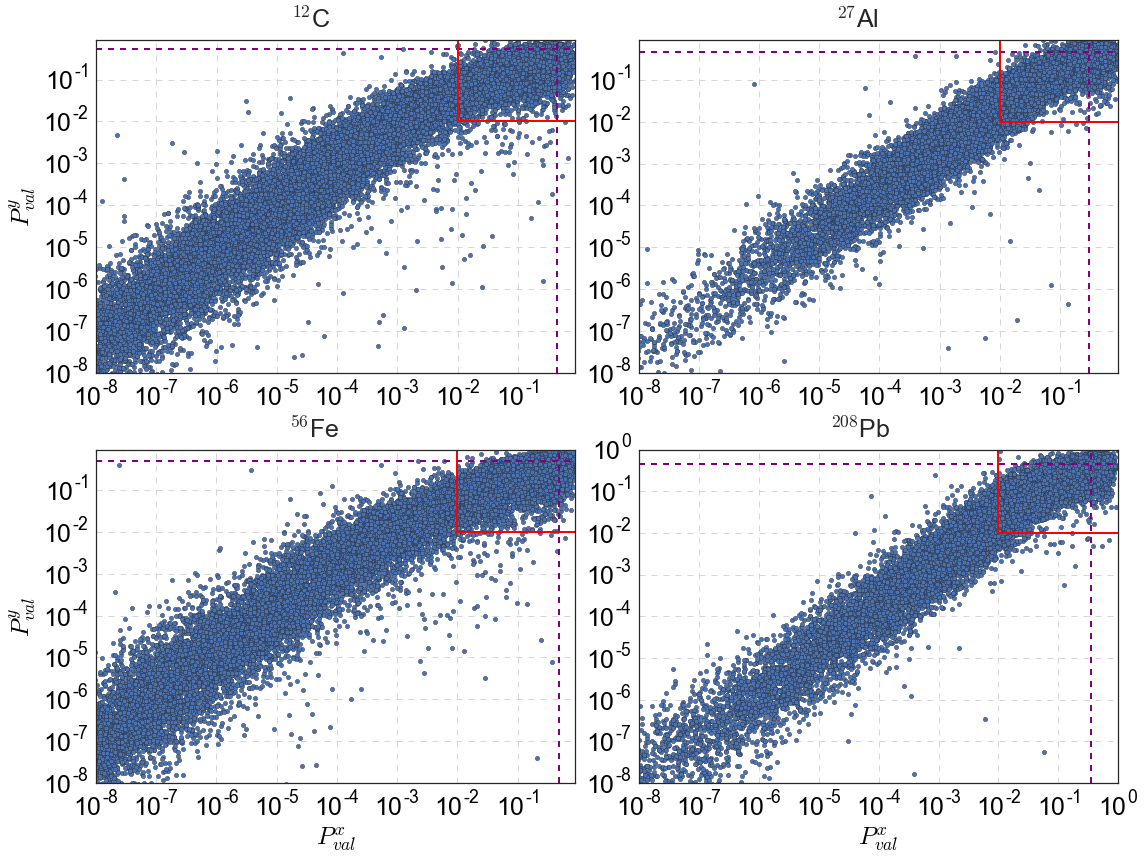

In [47]:
fig=plt.figure(figsize=(16,12))
bins=np.linspace(0,1,120)
for i,(A,target,target_name) in enumerate(zip(As,targets,target_names)):#{
    test_name = "simulations_"+target
    sims=simulation_results[test_name]
    sims=sims[(sims['chi2red_x']<100)&(sims['chi2red_y']<100)]
    ax=fig.add_subplot(2,2,i+1)
    
    # chi2(x) vs. Pval(x) 
#     plt.scatter( sims['chi2red_x'] , Pval_x )
#     plt.scatter( sims['chi2red_y'] , Pval_y )

    # 1D histograms of Pval(x) and Pval(y)
#     h,bins,_=plt.hist(Pval_x,bins=bins,color='royalblue',histtype='step',linewidth=3)
#     plt.plot([0,0],[0,0],linewidth=3,label='$x$ direction',color='royalblue')
#     h,bins,_=plt.hist(Pval_y,bins=bins,color='tomato',histtype='step',linewidth=3)
#     plt.plot([0,0],[0,0],linewidth=3,label='$y$ direction',color='tomato')
    
    # scatter plot of Pval(x) vs. Pval(y)
    plt.scatter( sims['Pval_x'] , sims['Pval_y'] )
    
    set_axes(ax
             ,r'$P_{val}^{x}$' if i>=2 else ''
             ,r'$P_{val}^{y}$' if i==0 or i==2 else ''
             ,do_add_grid=True
#              ,xlim=(1e-3,40)
             ,xlim=(1e-8,np.max(sims['Pval_x']))            
             ,ylim=(1e-8,np.max(sims['Pval_y']))
            )
    ax.set_xscale('log')
    ax.set_yscale('log')

    ax.set_title(target_name+'\t',y=1.02,fontsize=25)
    # the Pval of the data 
    cm_pars = cm_parameters['PrecFiducials']        
    cm_pars_target = cm_pars[cm_pars['A']==A]
    Pval_x_data,Pval_y_data = float(cm_pars_target['Pval_x']),float(cm_pars_target['Pval_y'])
    
    plt.plot([Pval_x_data,Pval_x_data],ax.get_ylim(),'--',color='purple',linewidth=2)
    plt.plot(ax.get_xlim(),[Pval_y_data,Pval_y_data],'--',color='purple',linewidth=2)

    plt.plot([cut_Pval_min,1],[cut_Pval_min,cut_Pval_min],'-',color='red',linewidth=2,label=r'$P_{val}^{Gaussian}>%.3f$ cut'%cut_Pval_min)
    plt.plot([cut_Pval_min,cut_Pval_min],[cut_Pval_min,1],'-',color='red',linewidth=2,label=r'$P_{val}^{Gaussian}>%.3f$ cut'%cut_Pval_min)
#     if i==0: ax.legend(fontsize=25,loc='center')
plt.tight_layout()

In [399]:
sample = cm_parameters_with_correction['PrecFiducials']
for extraname in ["cut_Pval_0.0001","cut_Pval_0.001","cut_Pval_0.01"]:
    #["cut_chi2_20.0_5.0_20.0_5.0","cut_chi2_10.0_4.0_10.0_4.0","cut_chi2_30.0_6.0_30.0_6.0","cut_chi2_100.0_100.0_100.0_100.0"]:
    for direction in ['x','y']:
        sample['sigma_'+direction+extraname+'_final'] = sample['sigma_'+direction+'_corrected'+extraname]
        for updw in ['up','dw']:
            sample['sigma_'+direction+extraname+'_final_'+updw+'_err_tot'] = sample['sigma_'+direction+'_corrected_'+updw+'_err_tot'+extraname]
            sample['sigma_'+direction+extraname+'_final_'+updw+'_err'] = sample['sigma_'+direction+extraname+'_final_'+updw+'_err_tot']

    sample['sigma_t'+extraname+'_corrected'] = 0.5*(sample['sigma_x_corrected'+extraname]+sample['sigma_y_corrected'+extraname])
    sample['sigma_t'+extraname+'_final'] = 0.5*(sample['sigma_x_corrected'+extraname]+sample['sigma_y_corrected'+extraname])

    for err_label in ['stat','sys','tot']:
        for updw in ['up','dw']:            
            sample['sigma_t'+extraname+'_final_'+updw+'_err_'+err_label] = 0.5*np.sqrt(np.square(sample['sigma_x_corrected_'+updw+'_err_'+err_label+extraname])                                                                         
                                                                                       +np.square(sample['sigma_y_corrected_'+updw+'_err_'+err_label+extraname]))
    for updw in ['up','dw']:
        sample['sigma_t'+extraname+'_final_'+updw+'_err'] = sample['sigma_t'+extraname+'_final_'+updw+'_err_tot']

In [293]:
cm_parameters_with_correction['PrecFiducials'][['sigma_t_before_acc_corr','sigma_t_before_acc_corr_err'
                                                ,'sigma_t_final'
                                                ,'sigma_t_final_up_err_stat','sigma_t_final_dw_err_stat'
                                                ,'sigma_t_final_up_err_sys','sigma_t_final_dw_err_sys'
                                                ,'sigma_t_final_up_err_tot','sigma_t_final_dw_err_tot']].astype(float)

,sigma_t_before_acc_corr,sigma_t_before_acc_corr_err,sigma_t_final,sigma_t_final_up_err_stat,sigma_t_final_dw_err_stat,sigma_t_final_up_err_sys,sigma_t_final_dw_err_sys,sigma_t_final_up_err_tot,sigma_t_final_dw_err_tot
0,0.160008,0.004905,0.144673,0.004648,0.004608,0.000453,0.000401,0.004670,0.004625
1,0.174126,0.009284,0.160498,0.009472,0.009253,0.000781,0.000609,0.009504,0.009273
2,0.182190,0.006045,0.164251,0.005772,0.005716,0.000750,0.000644,0.005820,0.005752
3,0.180172,0.013463,0.165508,0.014719,0.013955,0.002041,0.001333,0.014860,0.014019


In [366]:
from scipy.stats import chisqprob
# chisqprob(400, 1)
1 - stats.chi2.cdf(5, 1)

0.025347318677468311

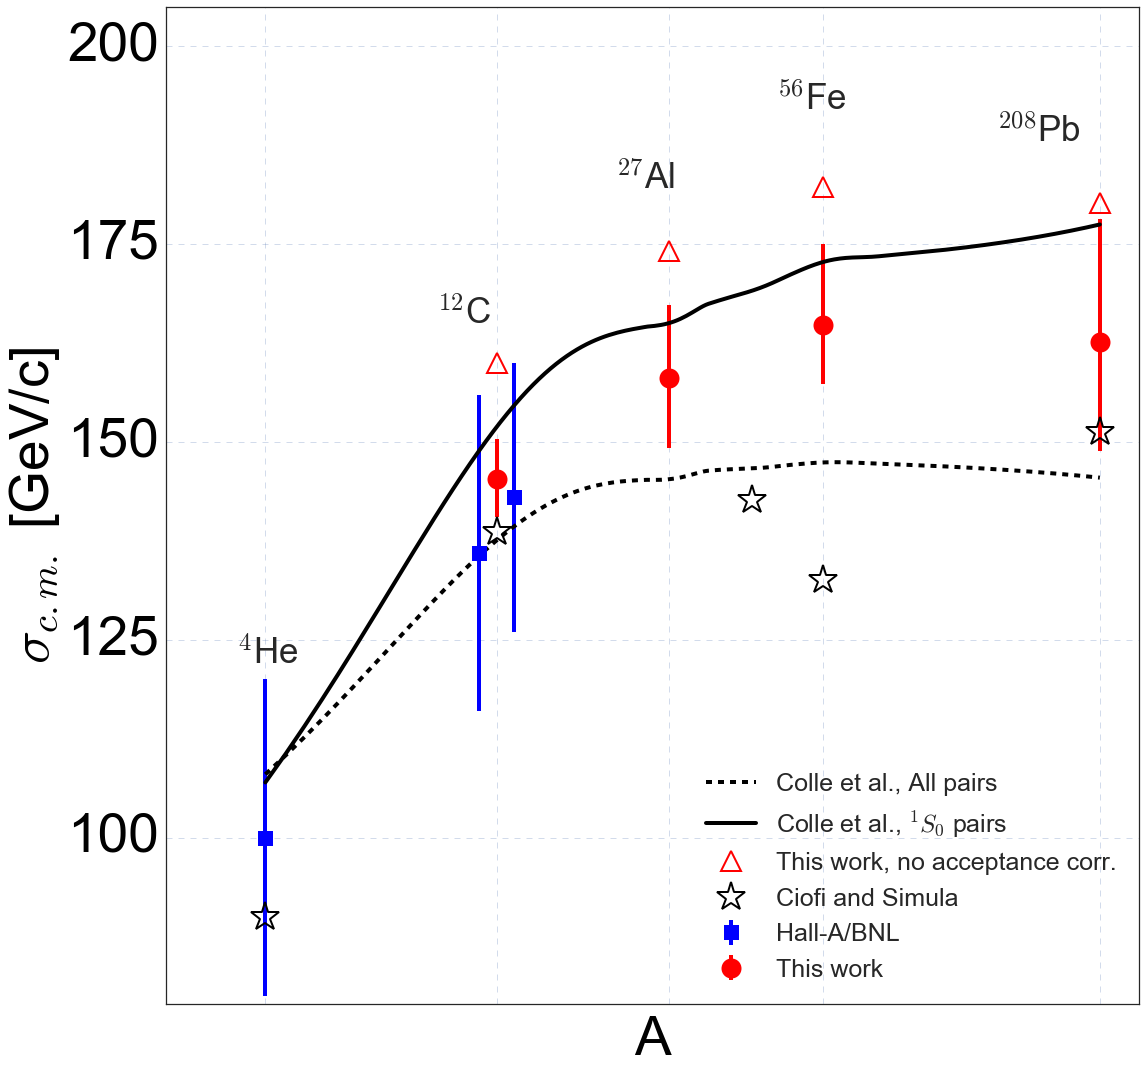

In [400]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(128,188), }),do_Ciofi=True)

extraname = "cut_Pval_0.01"
plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t'+extraname,ax=ax, label="This work" , marker='o', markersize=20 )
plt.legend(fontsize=20,loc='upper left')
# measured
ax.plot(cm_pars['A'], 1000*cm_pars['sigma_t_before_acc_corr'] ,mec='red' , marker='^' ,mfc='none',lw = 2, mew = 2, ms = 20, linewidth=0, label='This work, no acceptance corr.')
ax.legend(fontsize=25,loc='lower right')
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/results.pdf')    

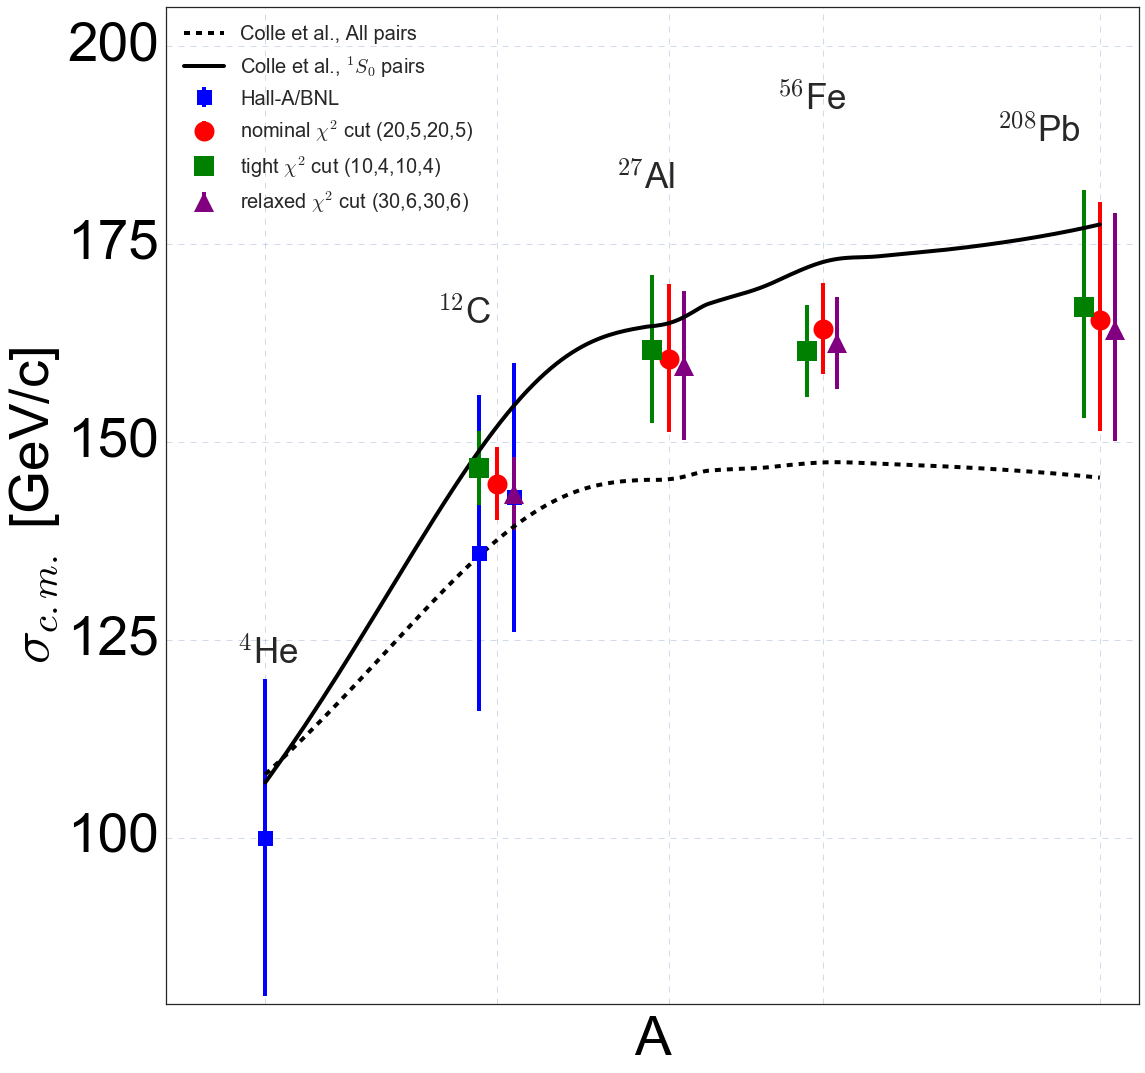

In [300]:
ax = plot_needed_for_A_depdendence_sigma_t(ylim=(79,205),labels=dict({'$^4$He':(3.5,122),
                                            '$^{12}$C':(9,165), '$^{27}$Al':(21,182),
                                            '$^{56}$Fe':(45,192), '$^{208}$Pb':(128,188), }),do_Ciofi=False)

for extraname,label,Ashift,marker,color in zip(["cut_chi2_20.0_5.0_20.0_5.0","cut_chi2_10.0_4.0_10.0_4.0","cut_chi2_30.0_6.0_30.0_6.0","cut_chi2_100.0_100.0_100.0_100.0"]
                                               ,[r'nominal $\chi^2$ cut (20,5,20,5)',r'tight $\chi^2$ cut (10,4,10,4)',r'relaxed $\chi^2$ cut (30,6,30,6)']#,'no $\chi^2$ cut']
                                               ,[[0,0,0,0],[-1,-2,-4,-15],[1,2,4,15],[2,3,6,25]]
                                               ,['o','s','^','v'],['red','green','purple','black']):
    plot_data_assymetric( data=cm_parameters_with_correction['PrecFiducials'],direction='t'+extraname, Ashift=Ashift,ax=ax, label=label , color=color, marker=marker, markersize=20 )
plt.legend(fontsize=20,loc='upper left')
plt.tight_layout()
plt.savefig('/Users/erezcohen/Desktop/results_cut_chi2_sensitivity.pdf')